# Library

In [ ]:
!pip install anaconda

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install folium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# 최적 파라미터를 범위내에서 찾아주는 라이브러리로써 캐글에서 인기 폭발이라고 한다.
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 4.0 MB/s 
     |████████████████████████████████| 209 kB 55.6 MB/s 
     |████████████████████████████████| 81 kB 10.8 MB/s 
     |████████████████████████████████| 78 kB 1.8 MB/s 
     |████████████████████████████████| 50 kB 7.3 MB/s 
     |████████████████████████████████| 112 kB 65.4 MB/s 
     |████████████████████████████████| 147 kB 65.5 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=90b4c1689f8324475880c72664578b0c88d86bcbe566a9903f72a15857bbf5da
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 131.9 MB/s 


In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
#한글폰트 설치. 런타임재사용 필요

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 12 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 0s (22.1 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

# Google_Drive 연동 및 데이터 불러오기.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
#구글드라이브연동

Mounted at /content/drive


In [2]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import gc

plt.style.use('seaborn')
sns.set(font_scale=1)
plt.rc('font', family='NanumBarunGothic') 
plt.rcParams['font.family'] = 'NanumGothic'
#한글폰트

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
def csv_to_parquet(csv_path, save_name):
    df = pd.read_csv(csv_path)
    df.to_parquet(f'./{save_name}.parquet')
    del df
    gc.collect()
    print(save_name, 'Done.')

In [4]:
csv_to_parquet('/content/drive/MyDrive/DACON_Dataset/JEJU_Traffic/open.zip (Unzipped Files)/train.csv','train')
csv_to_parquet('/content/drive/MyDrive/DACON_Dataset/JEJU_Traffic/open.zip (Unzipped Files)/test.csv','test')

# 22sec #파일경로

train Done.
test Done.


In [5]:
train=pd.read_parquet('train.parquet')
test=pd.read_parquet('test.parquet')

In [ ]:
train.road_rating.unique()

array([106, 103, 107])

In [6]:
train1=pd.read_parquet('train.parquet')
test1=pd.read_parquet('test.parquet')

In [ ]:
train['base_hour']=train1.base_hour
test['base_hour']=test1.base_hour

In [10]:
train.head(10)

,id,base_date,day_of_week,base_hour,road_in_use,lane_count,road_rating,road_name,multi_linked,connect_code,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
0,TRAIN_0000000,20220623,목,17,0,1,106,지방도1112호선,0,0,...,3,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0
1,TRAIN_0000001,20220728,목,21,0,2,103,일반국도11호선,0,0,...,0,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0
2,TRAIN_0000002,20211010,일,7,0,2,103,일반국도16호선,0,0,...,0,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0
3,TRAIN_0000003,20220311,금,13,0,2,107,태평로,0,0,...,0,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0
4,TRAIN_0000004,20211005,화,8,0,2,103,일반국도12호선,0,0,...,0,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0
5,TRAIN_0000005,20210913,월,7,0,2,107,경찰로,0,0,...,0,시청입구2,33.249949,126.505664,없음,서호2차현대맨션203동,33.252183,126.506069,없음,28.0
6,TRAIN_0000006,20220106,목,0,0,2,107,-,0,0,...,0,가동,33.418412,126.268029,없음,나동,33.414175,126.269378,없음,39.0
7,TRAIN_0000007,20211213,월,16,0,2,107,외도천교,0,0,...,3,외도천교,33.482392,126.441622,없음,외도천교,33.482332,126.442266,없음,28.0
8,TRAIN_0000008,20211004,월,15,0,2,107,경찰로,0,0,...,0,신성교회,33.253074,126.506393,없음,서호2차현대맨션203동,33.252183,126.506069,없음,14.0
9,TRAIN_0000009,20211208,수,2,0,1,103,일반국도16호선,0,0,...,0,양수장,33.361717,126.766958,없음,제2가시교,33.364336,126.769409,없음,52.0


# Description
 
- 470만 1217개의 행으로 구성되어 있고, 281개의 일수에서의 요일 값과 24시간 각 시간, 도로 사용여부(0,1), 차선수는 3차선이 최대입니다. 도로등급은 106, 103, 107로 제주도에는 3가지의 등급 밖에 없는것으로 여겨집니다.


- 도로명은 61가지가 있으며, 중용구간(2개이상의 노선이 공동으로 사용하는 공간)일수도 있고 아닐 수 도 있습니다. 연결로코드 는 0혹은 103이 될 수 있습니다. 속도제한은 6가지 제한이 있으며, 30-80까지 10단위로 총 6개가 존재합니다. 차량제한(drop)은 없지만, 하중제한은 [32400.,     0., 43200., 50000.]이렇게 존재하고, 높이제한(drop)도 없습니다. 


-  도로유형은 3번타입 아니면 0번타입 두가지입니다. 시작지점명, 도착지점명은 487곳이고, 시작위경도는 586 * (x,y) 시작, 도착 지점의 회전가능여부도 존재합니다.


# Column Description

        id	아이디
        base_date	날짜
        day_of_week	요일
        base_hour	시간대
        road_in_use	도로사용여부
        lane_count	차로수
        road_rating	도로등급
        multi_linked	중용구간 여부
        connect_code	연결로 코드
        maximum_speed_limit	최고속도제한
        weight_restricted	통과제한하중
        hight_restricted	통과제한높이
        road_type	도로유형
        start_latitude	시작지점의 위도
        start_longitude	시작지점의 경도
        start_turn_restricted	시작 지점의 회전제한 유무
        end_latitude	도착지점의 위도
        end_longitude	도착지점의 경도
        end_turn_restricted	도작지점의 회전제한 유무
        road_name	도로명
        start_node_name	시작지점명
        end_node_name	도착지점명
        vehicle_restricted	통과제한차량
        target	평균속도(km) 

# Numeric vs Categorical
틀린것 있을 수 도 있음. ㅋ

        Numeric : 

        base_date ,base_hour lane_count , maximum_speed_limit, weight_restricted, 
        height_restricted , start_latitude, start_longitude, end_latitude, end_longitude

        Categorical :

        id, day_of_week, road_in_use, road_rating, multi_linked, connect_code,
        start_turn_restricted, road_type, end_turn_restricted, road_name,
        start_node_name, end_node_name, vehicle_restricted

        Target : target ( 평균속도)

# EDA
- 결측치는 존재하지 않습니다.

In [ ]:
train.isnull().sum() # wow 제주 대신 train으로 변경할것.

id                       0
base_date                0
day_of_week              0
base_hour                0
road_in_use              0
lane_count               0
road_rating              0
road_name                0
multi_linked             0
connect_code             0
maximum_speed_limit      0
vehicle_restricted       0
weight_restricted        0
height_restricted        0
road_type                0
start_node_name          0
start_latitude           0
start_longitude          0
start_turn_restricted    0
end_node_name            0
end_latitude             0
end_longitude            0
end_turn_restricted      0
target                   0
dtype: int64

-상관계수 분석하기.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53945 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/b

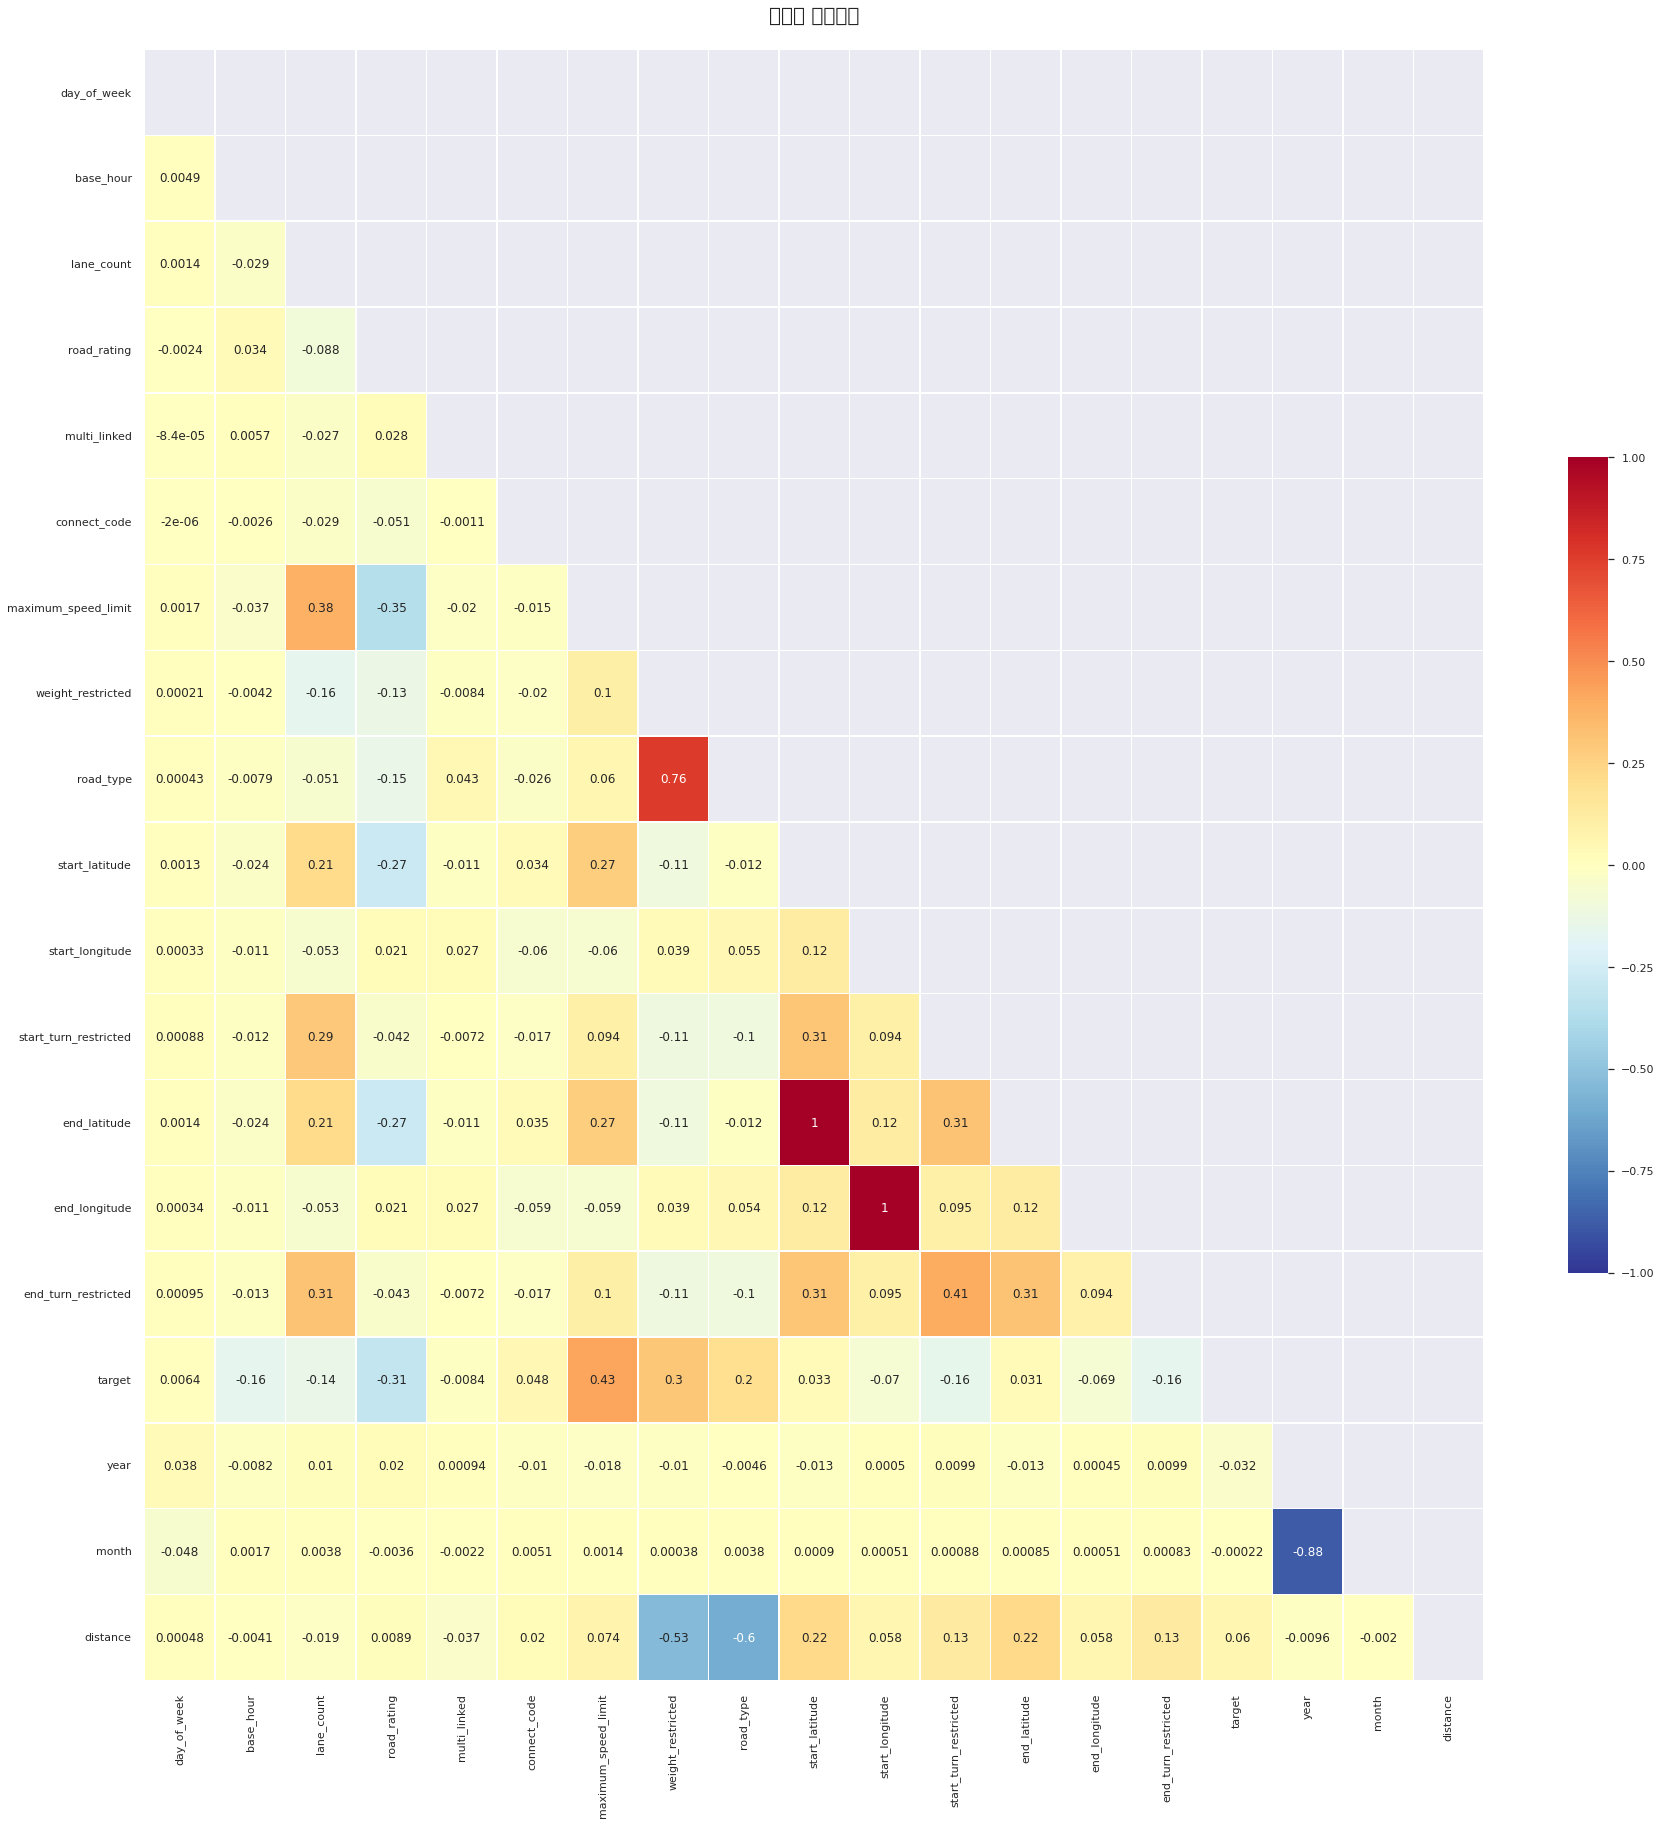

In [ ]:
data = train.corr()
# 그림 사이즈 지정
fig, ax = plt.subplots( figsize=(30,30) )

# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(data, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# 히트맵을 그린다
sns.heatmap(data, 
            cmap = 'RdYlBu_r', 
            annot = True,   # 실제 값을 표시한다
            mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .5},# 컬러바 크기 절반으로 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )
plt.title('특성별 상관관계\n',fontsize=20)  
plt.show()

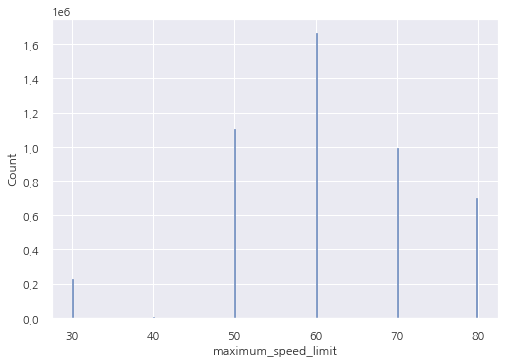

In [ ]:
sns.histplot(data=train['maximum_speed_limit'])

Text(0.5, 1.0, 'target')

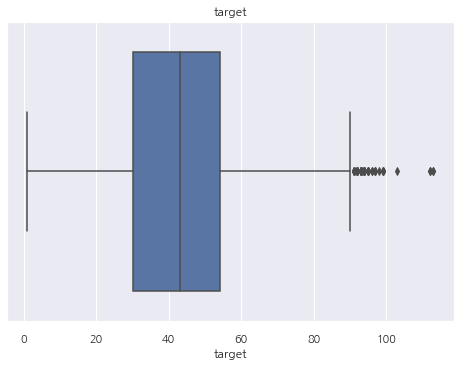

In [ ]:
sns.boxplot(data=train,x='target')
plt.title('target')

In [ ]:
sns.countplot(data=train, x=train['day_of_week']);

In [ ]:
sns.countplot(data=train, x=train['base_hour']);

In [ ]:
sns.countplot(data=train, x=train['road_in_use']);

train['road_in_use'].value_counts() # 개수

print('도로를 사용하지 않을 때 평균속도의 mean',train[train['road_in_use']==0]['target'].mean())

print('도로를 사용할때 평균속도의 mean',train[train['road_in_use']==1]['target'].mean())

In [ ]:
# 컬럼별 target분포 히스토그램.
def value_hist(df, col, target='target'):

  for value in df[col].unique():

    cond = (df[col]==value)
    cond_df = df.loc[cond]

    print(f'{value} 데이터 갯수 : {cond_df.shape[0]}')

    

    fig, ax = plt.subplots(ncols=2, figsize=(13, 6))

    sns.histplot(data=cond_df, x='target', ax=ax[0])
    ax[0].set_title(f'{col}의 {value} 히스토그램')
    ax[0].set_xticks(range(0,int(df[target].max()+1)), 20)

    sns.boxplot(data=cond_df, x='target', ax=ax[1])
    ax[1].set_title(f'{col}의 {value} Box Plot')
    
    plt.show()

In [ ]:
train.columns

Index(['id', 'base_date', 'day_of_week', 'base_hour', 'road_in_use',
       'lane_count', 'road_rating', 'road_name', 'multi_linked',
       'connect_code', 'maximum_speed_limit', 'vehicle_restricted',
       'weight_restricted', 'height_restricted', 'road_type',
       'start_node_name', 'start_latitude', 'start_longitude',
       'start_turn_restricted', 'end_node_name', 'end_latitude',
       'end_longitude', 'end_turn_restricted', 'target'],
      dtype='object')

In [ ]:
train.road_name.unique()

NameError: ignored

In [ ]:
value_hist(train,'day_of_week') #요일 별 target 히스토그램.

17 데이터 갯수 : 208377


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


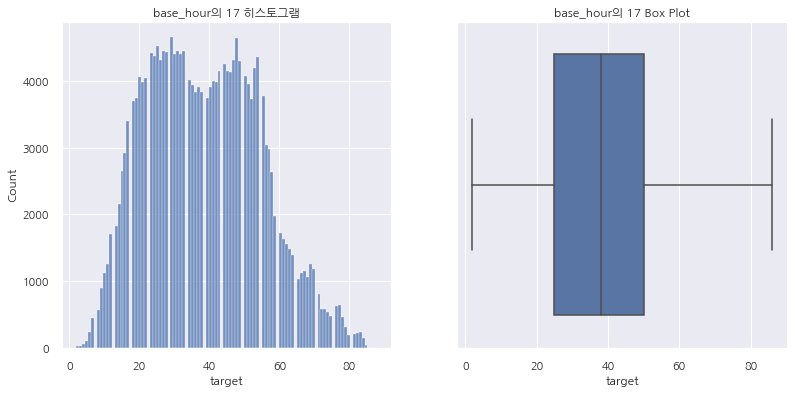

21 데이터 갯수 : 203583


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


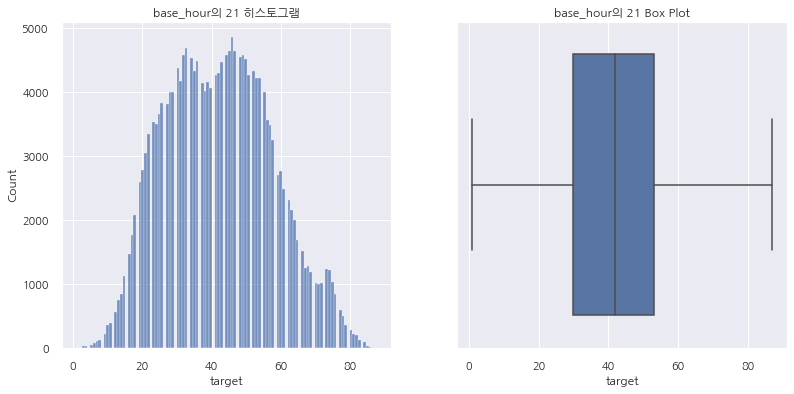

7 데이터 갯수 : 199061


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


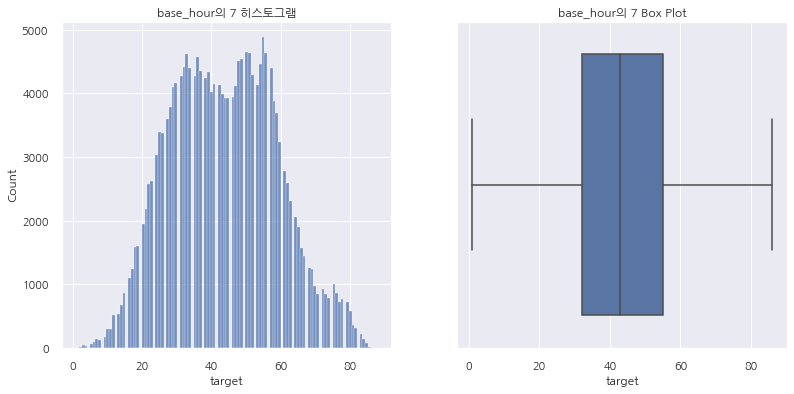

13 데이터 갯수 : 214297


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


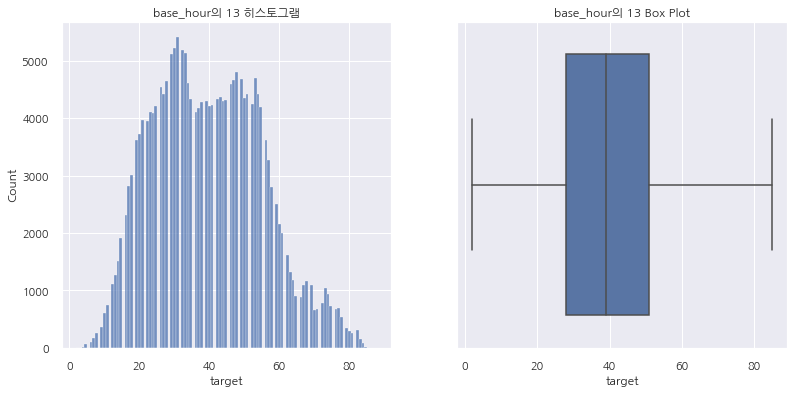

8 데이터 갯수 : 201875


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


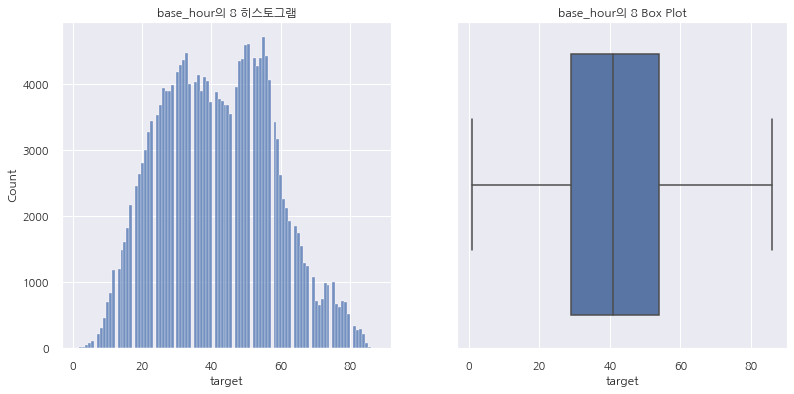

0 데이터 갯수 : 154045


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


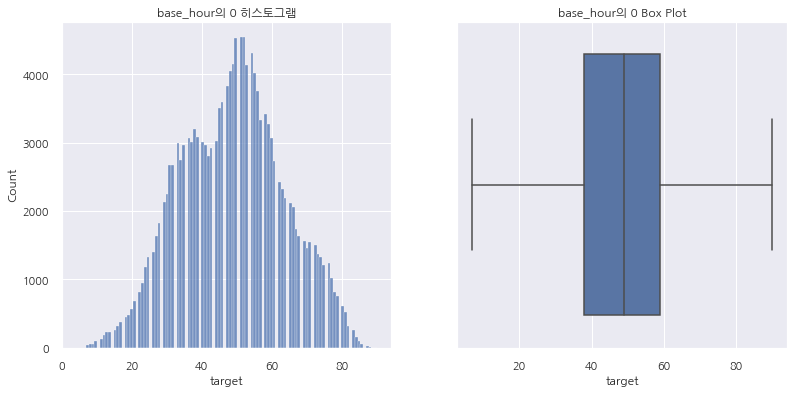

16 데이터 갯수 : 208420


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


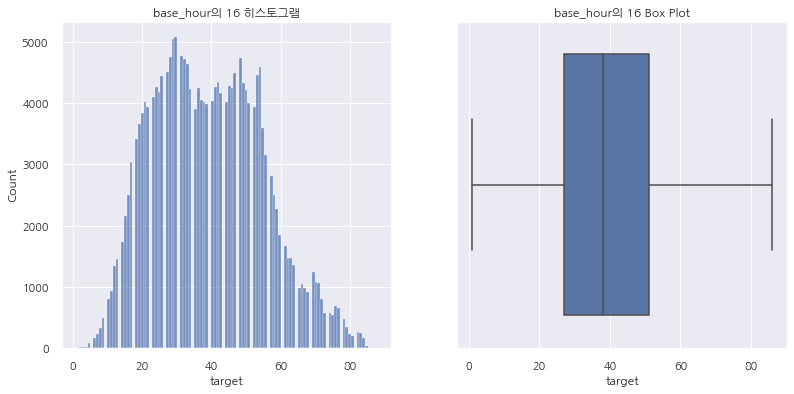

15 데이터 갯수 : 214541


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


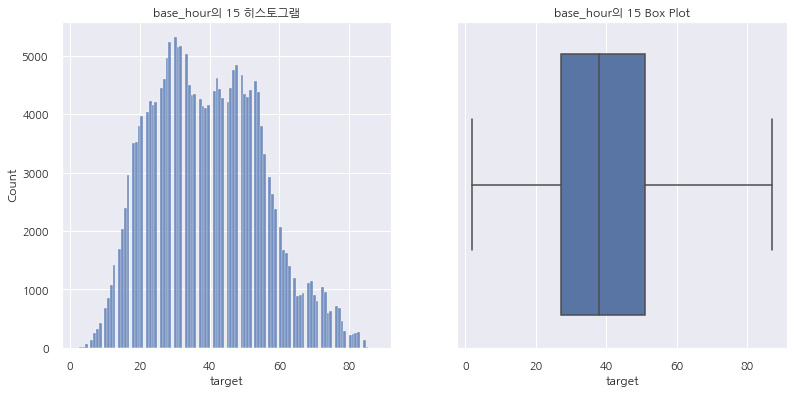

2 데이터 갯수 : 169128


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


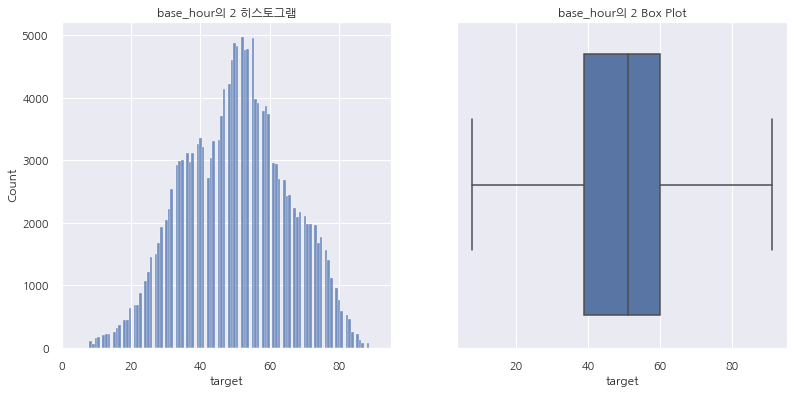

11 데이터 갯수 : 208515


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


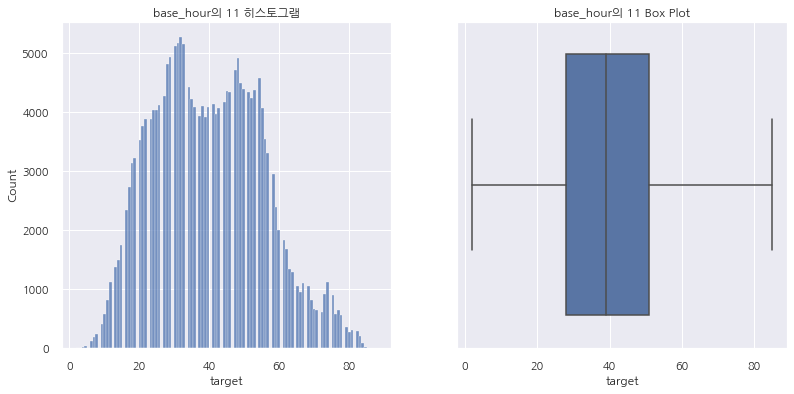

10 데이터 갯수 : 206316


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


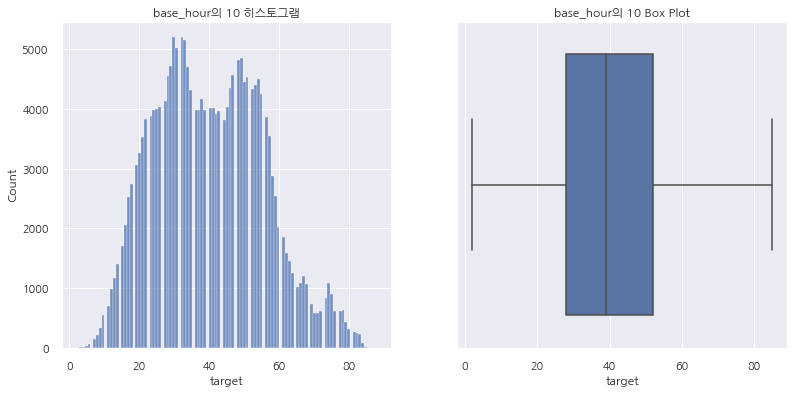

22 데이터 갯수 : 200627


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


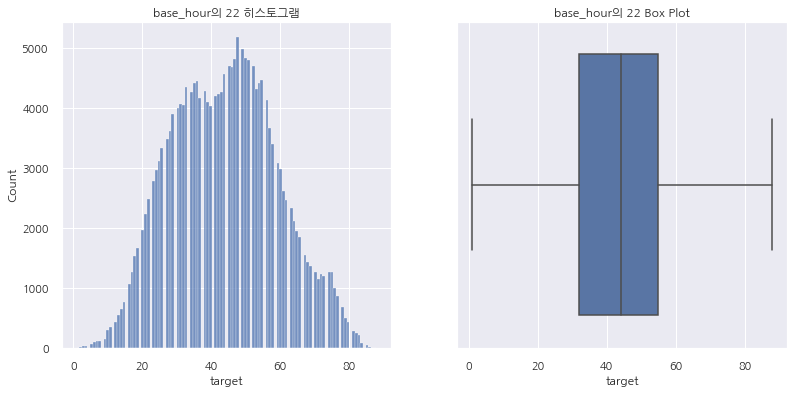

12 데이터 갯수 : 211833


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


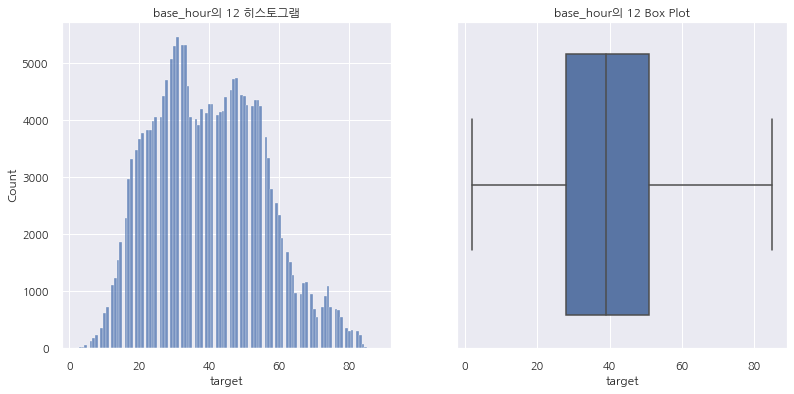

23 데이터 갯수 : 184227


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


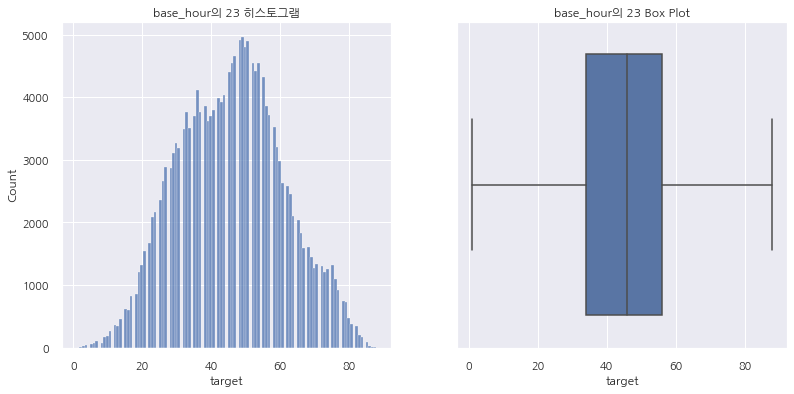

14 데이터 갯수 : 214177


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


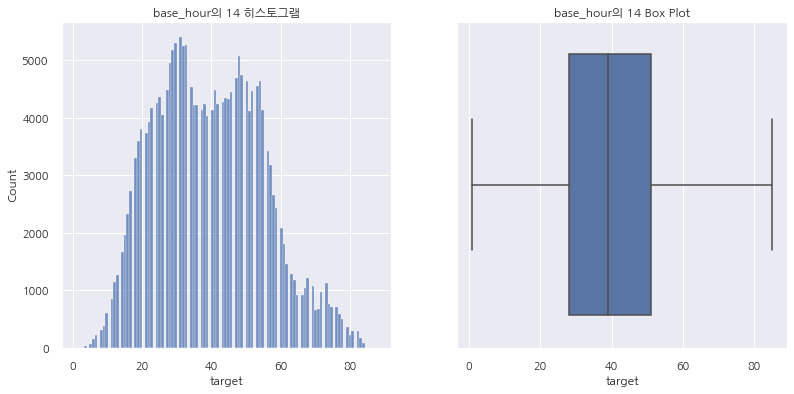

6 데이터 갯수 : 189418


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


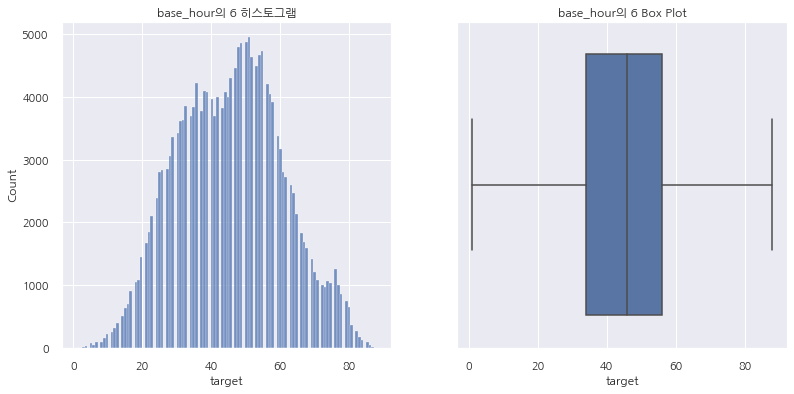

9 데이터 갯수 : 205327


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


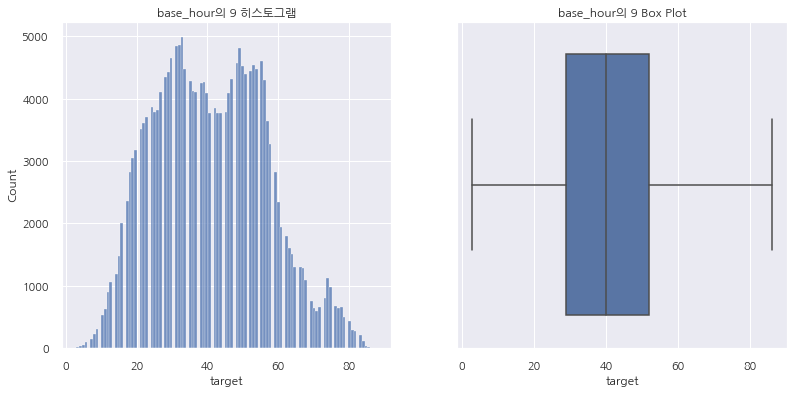

19 데이터 갯수 : 209861


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


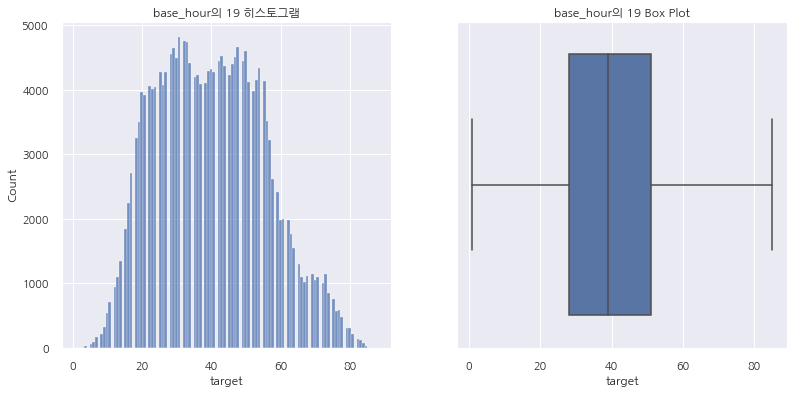

1 데이터 갯수 : 182197


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


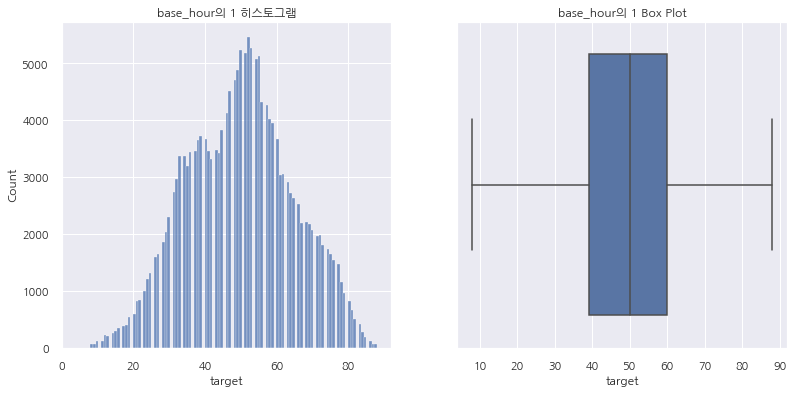

4 데이터 갯수 : 164993


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


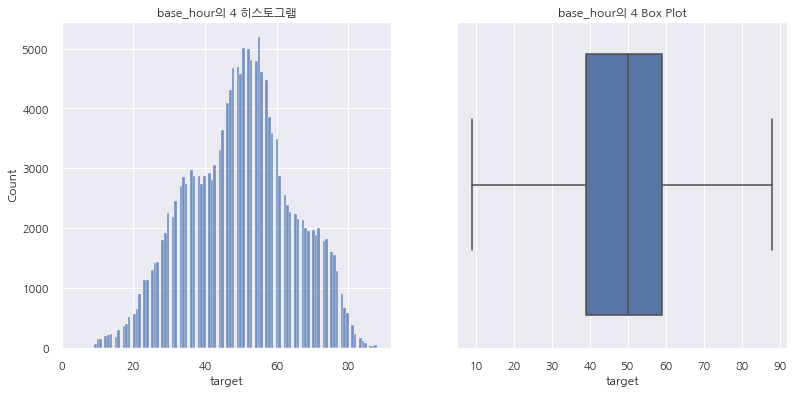

20 데이터 갯수 : 205056


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


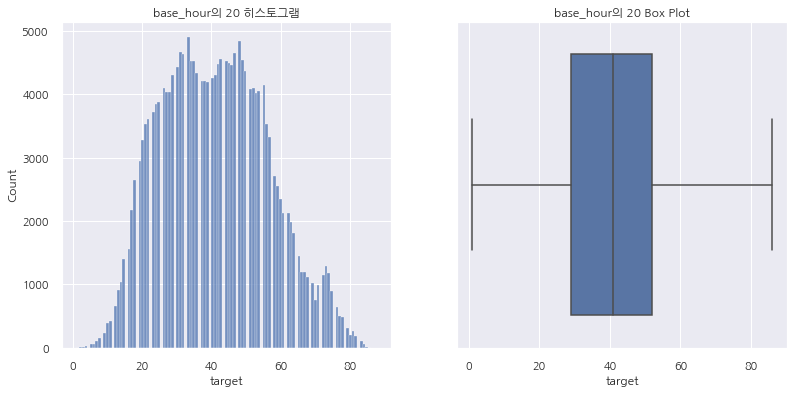

18 데이터 갯수 : 207500


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


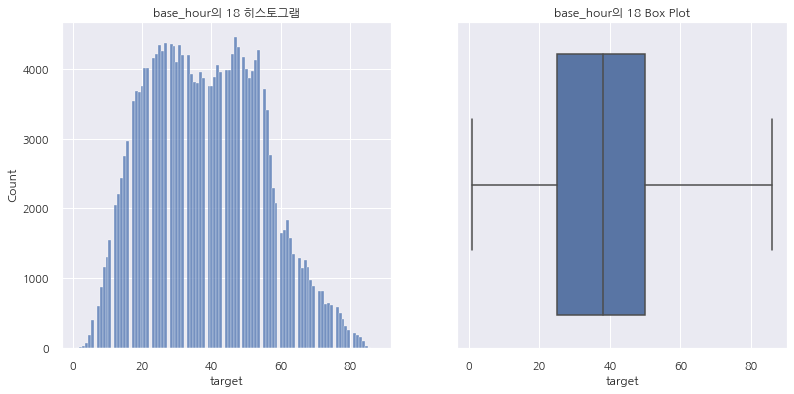

3 데이터 갯수 : 155748


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


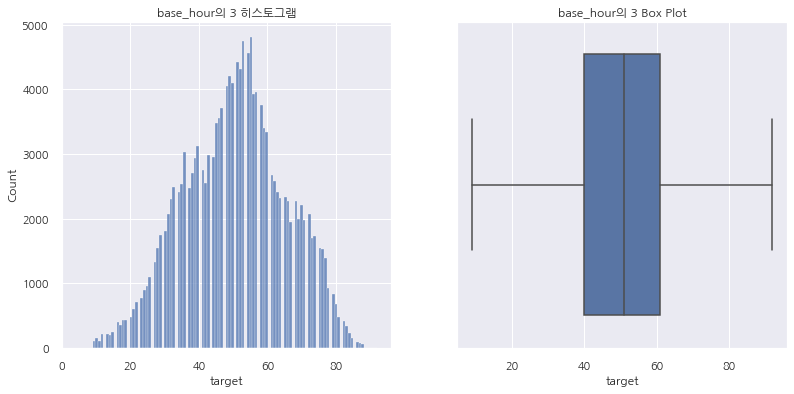

5 데이터 갯수 : 181052


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


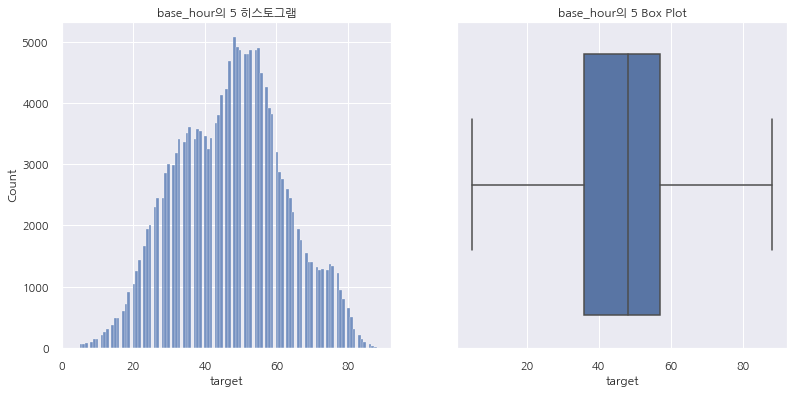

In [ ]:
value_hist(train,'base_hour')

106 데이터 갯수 : 959492


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/back

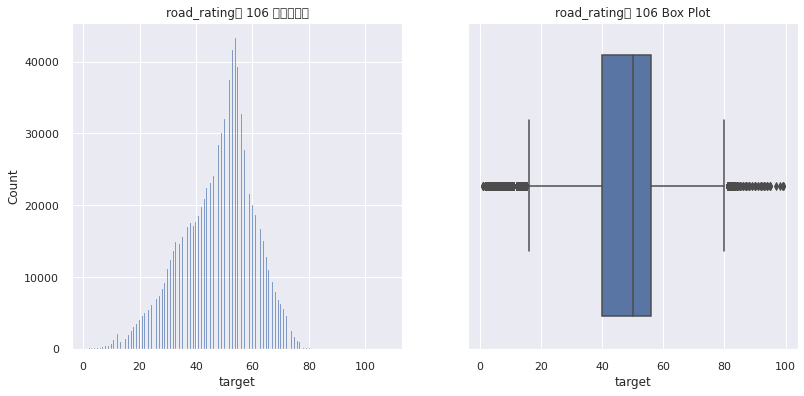

103 데이터 갯수 : 2159511


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/back

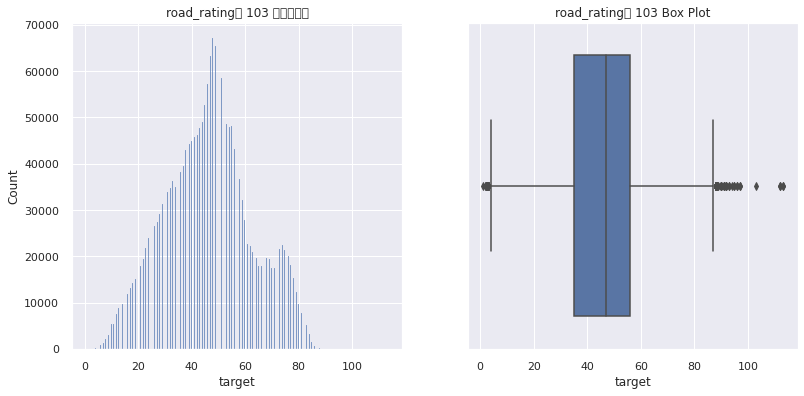

107 데이터 갯수 : 1582214


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/back

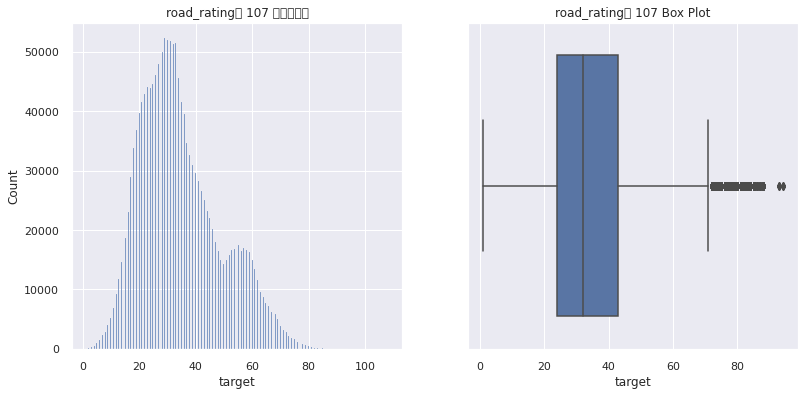

In [ ]:
value_hist(train,'road_rating')

1 데이터 갯수 : 1555298


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


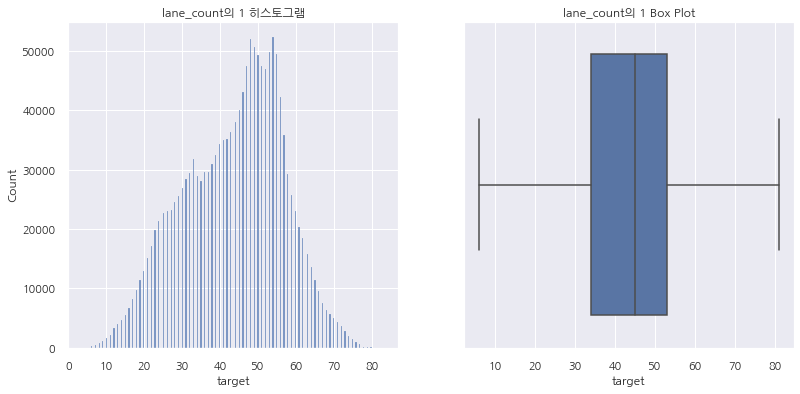

2 데이터 갯수 : 2334285


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


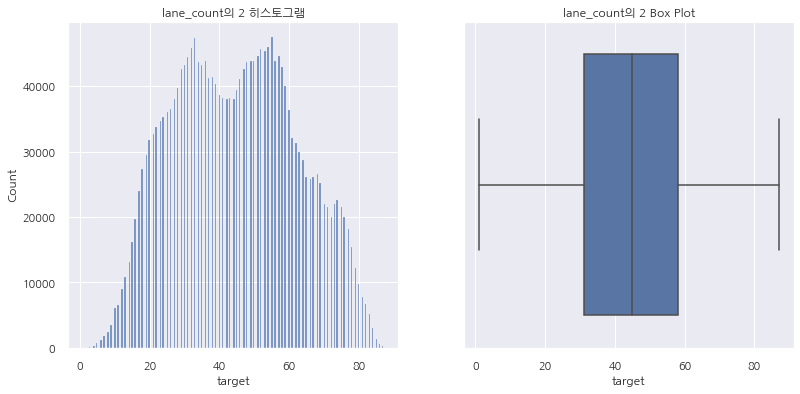

3 데이터 갯수 : 787199


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


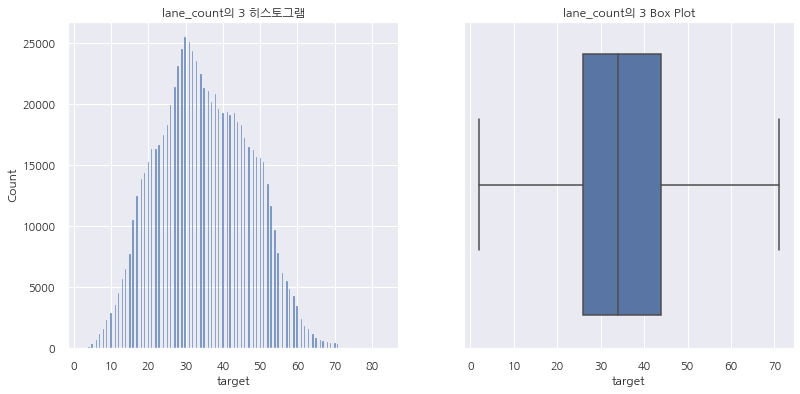

In [ ]:
value_hist(train,'lane_count')

0 데이터 갯수 : 4239599


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


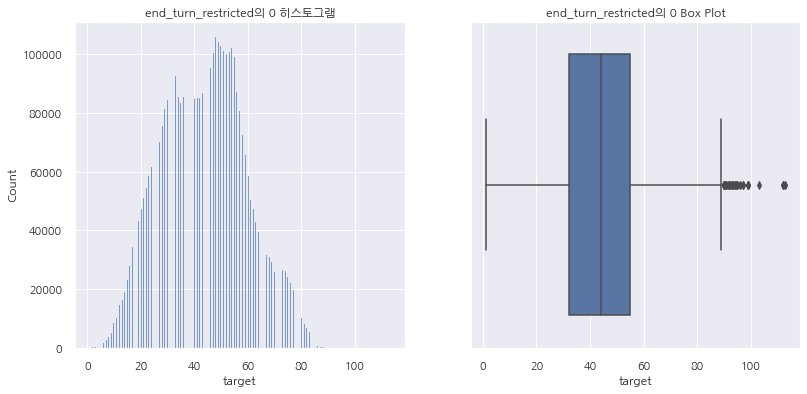

1 데이터 갯수 : 461618


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


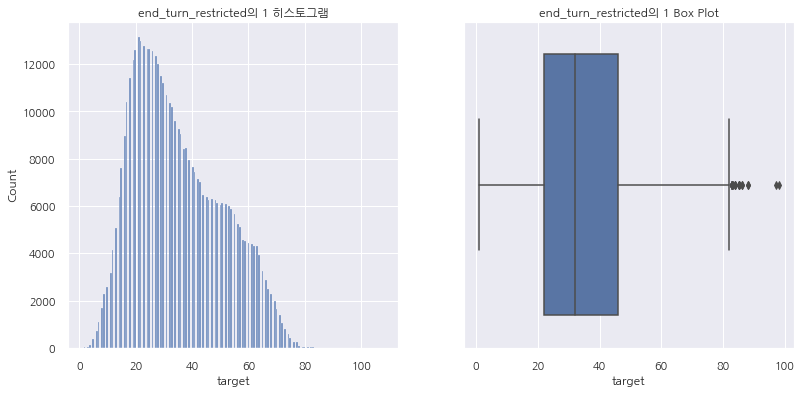

In [ ]:
value_hist(train,'end_turn_restricted')

0 데이터 갯수 : 4239701


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


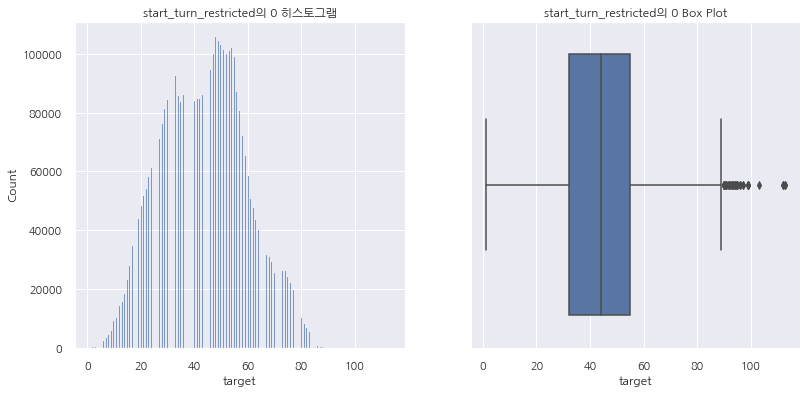

1 데이터 갯수 : 461516


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


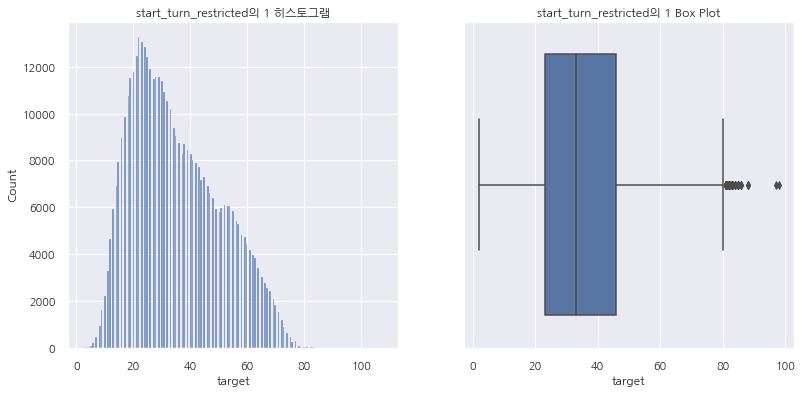

In [ ]:
value_hist(train,'start_turn_restricted')

21 데이터 갯수 : 91077


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/back

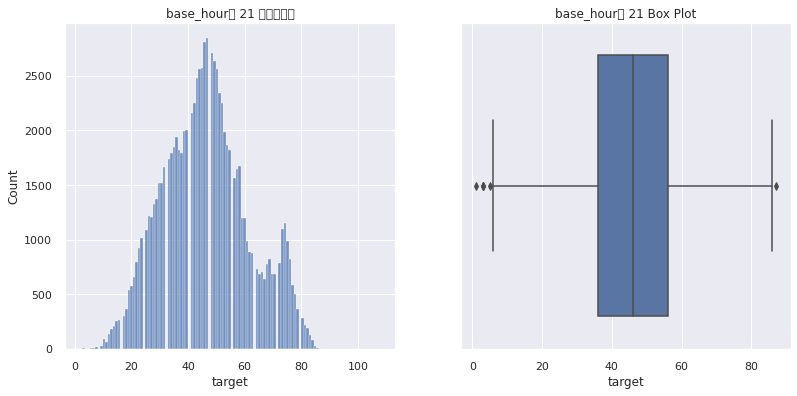

7 데이터 갯수 : 91000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/back

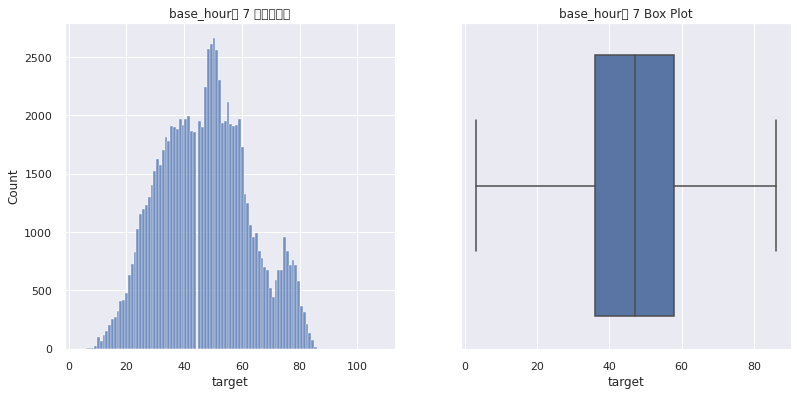

8 데이터 갯수 : 90568


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/back

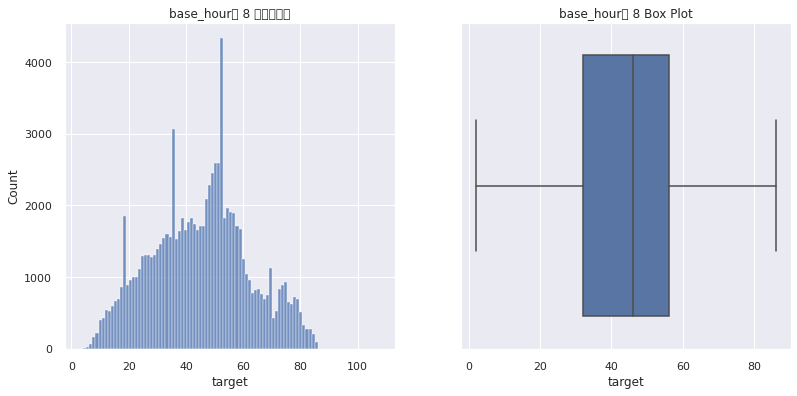

2 데이터 갯수 : 85202


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/back

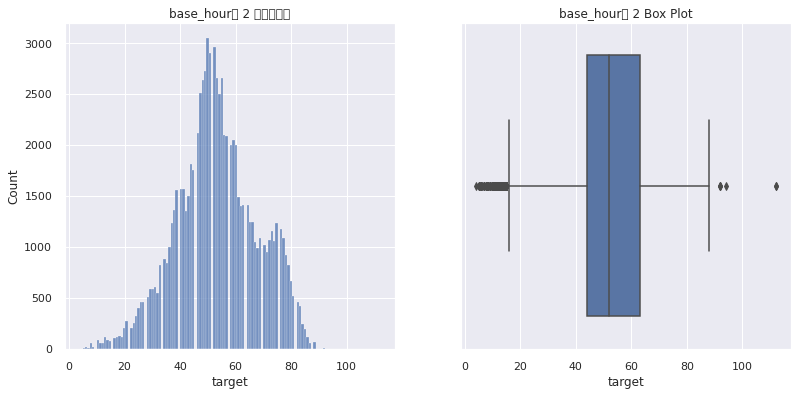

11 데이터 갯수 : 92978


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/back

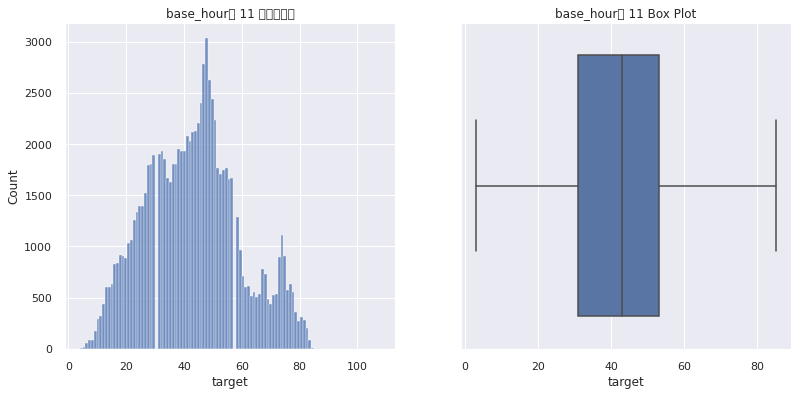

16 데이터 갯수 : 93010


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/back

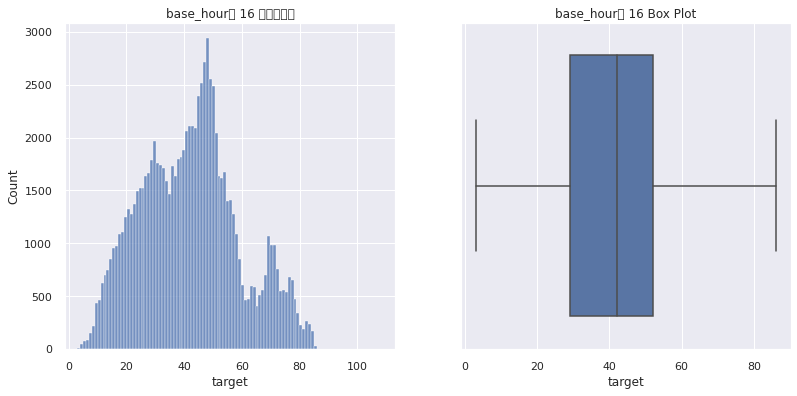

12 데이터 갯수 : 94541


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/back

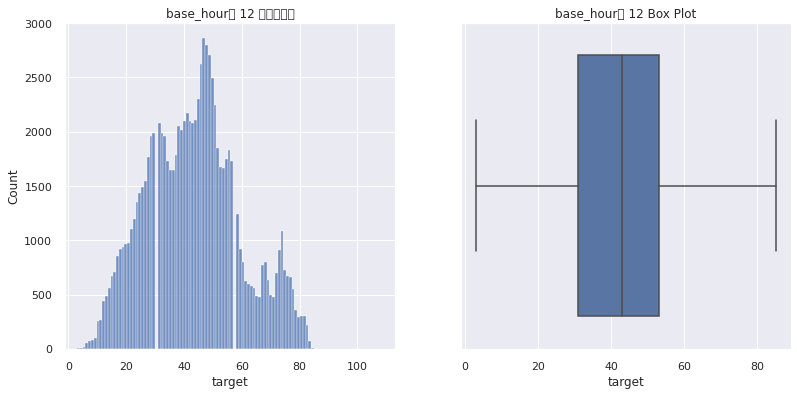

0 데이터 갯수 : 74203


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/back

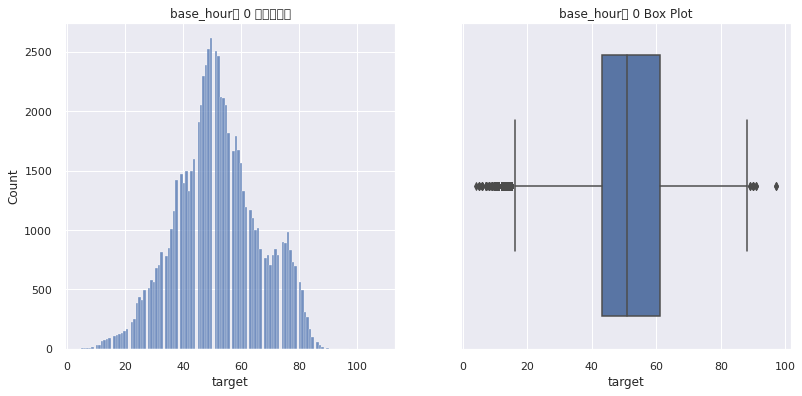

22 데이터 갯수 : 91139


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/back

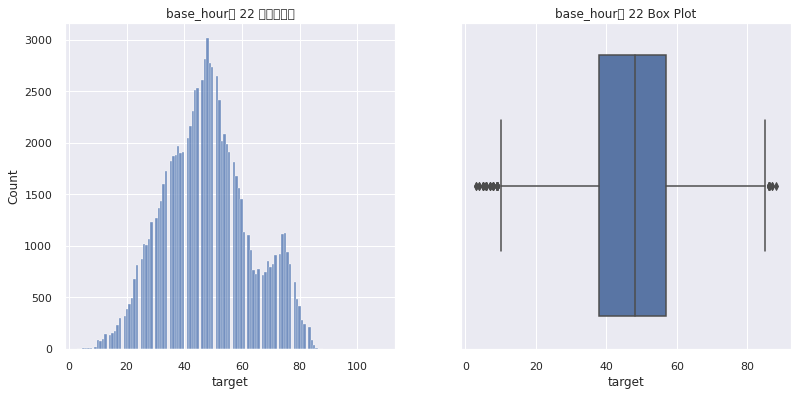

19 데이터 갯수 : 93382


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/back

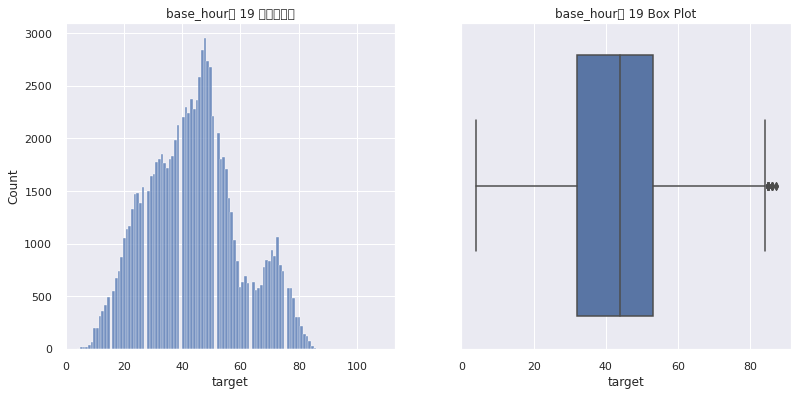

6 데이터 갯수 : 88968


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/back

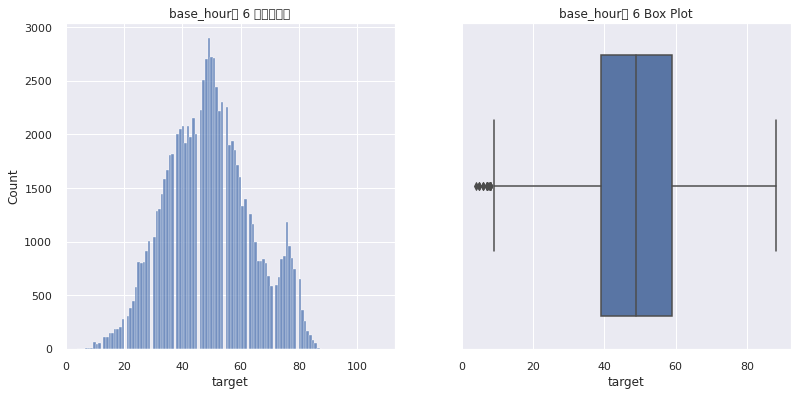

14 데이터 갯수 : 95624


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/back

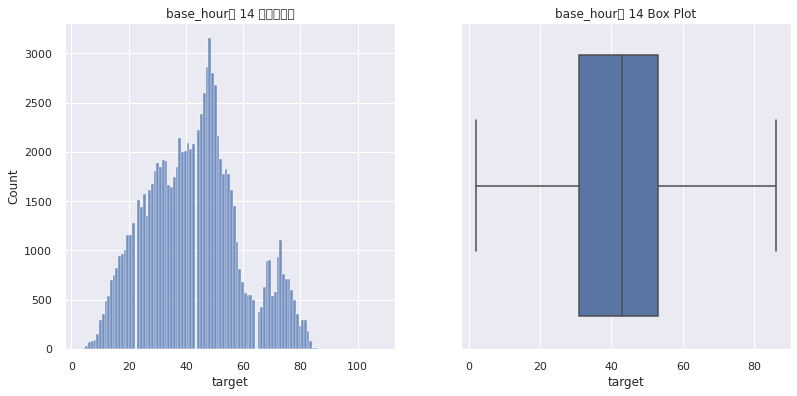

13 데이터 갯수 : 95772


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/back

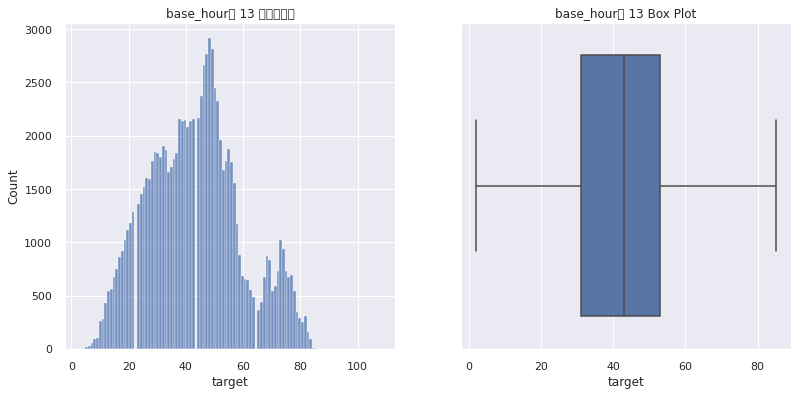

4 데이터 갯수 : 83442


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/back

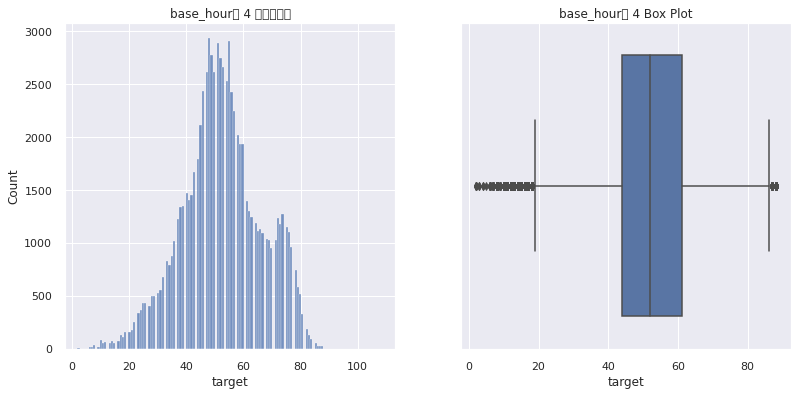

10 데이터 갯수 : 91926


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/back

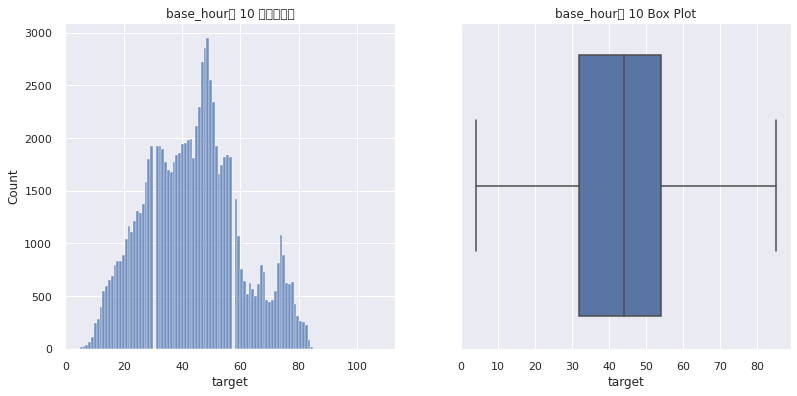

15 데이터 갯수 : 95765


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/back

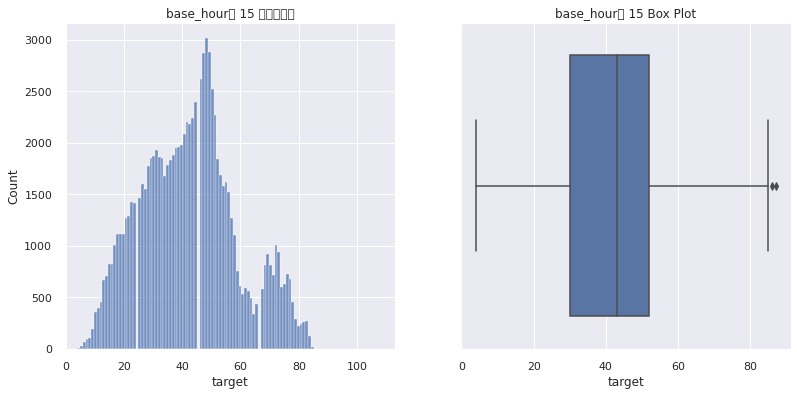

20 데이터 갯수 : 91305


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/back

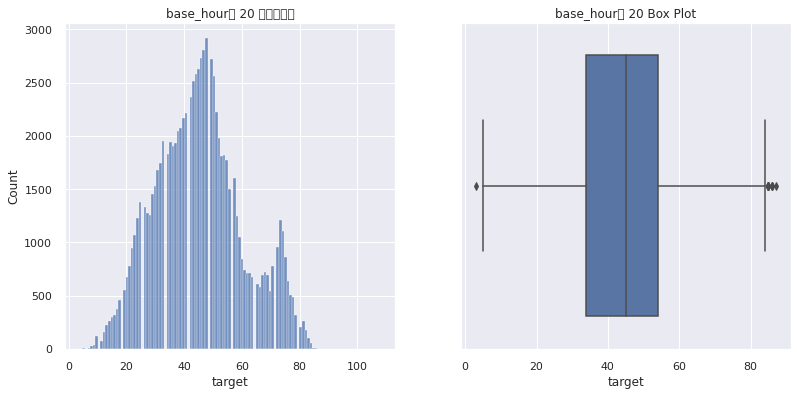

17 데이터 갯수 : 92985


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/back

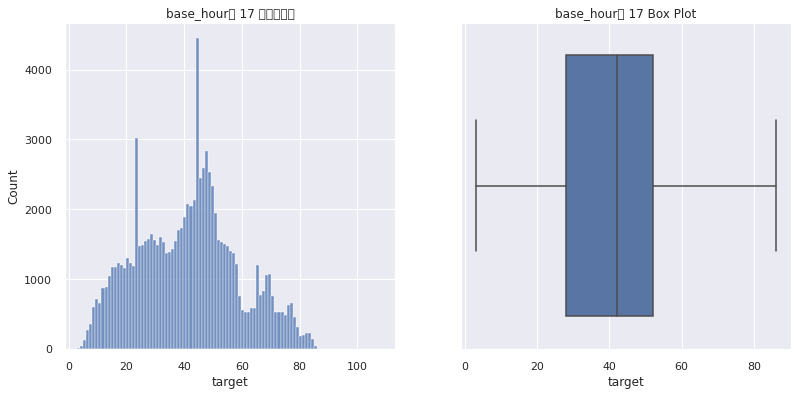

9 데이터 갯수 : 91443


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/back

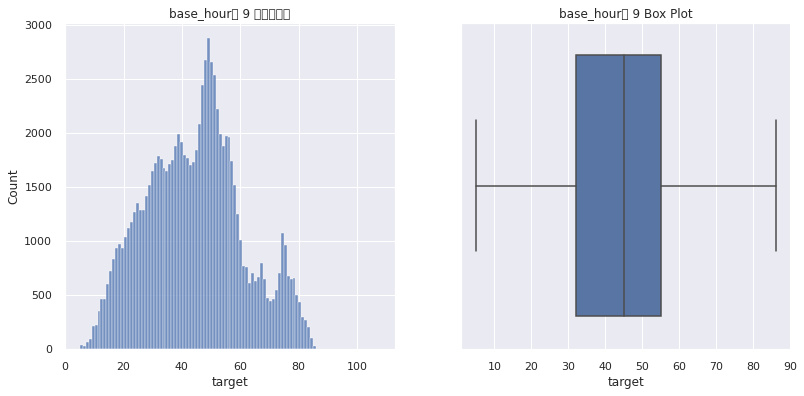

5 데이터 갯수 : 87590


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/back

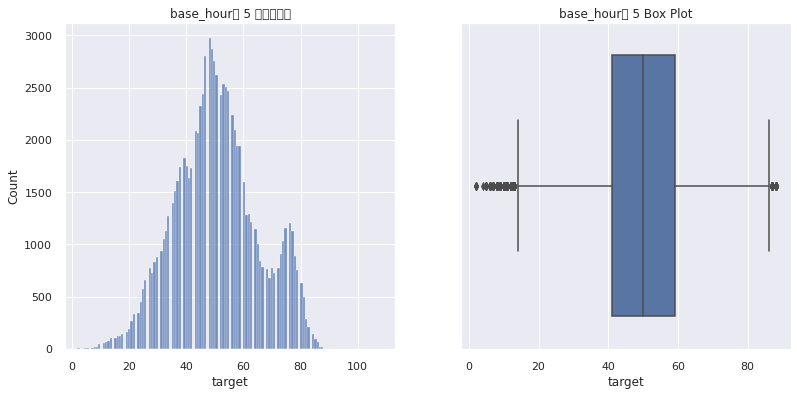

1 데이터 갯수 : 89251


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/back

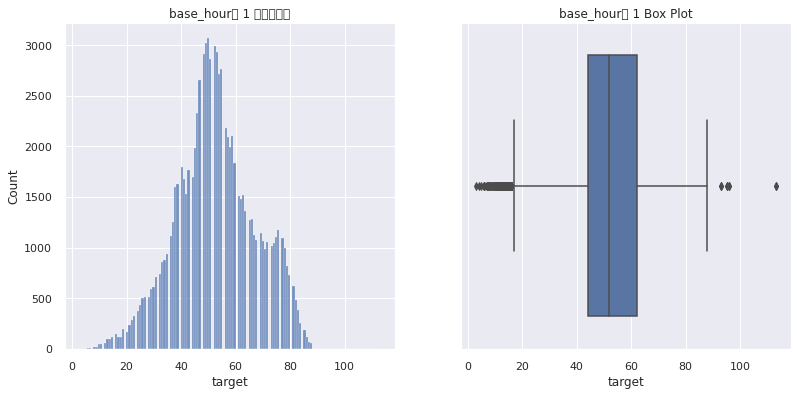

18 데이터 갯수 : 92495


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/back

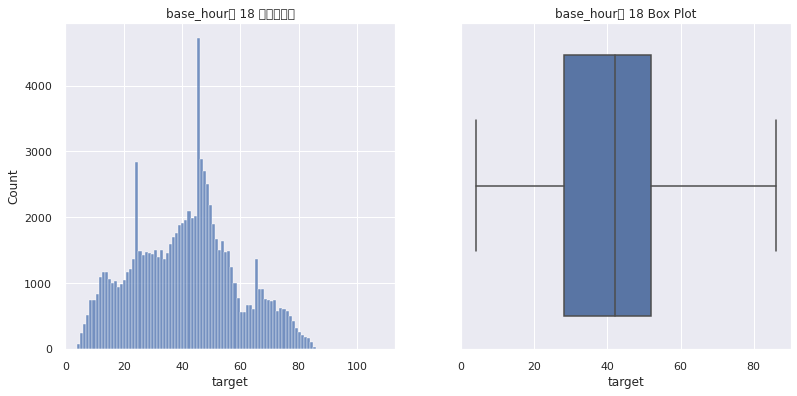

3 데이터 갯수 : 79920


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/back

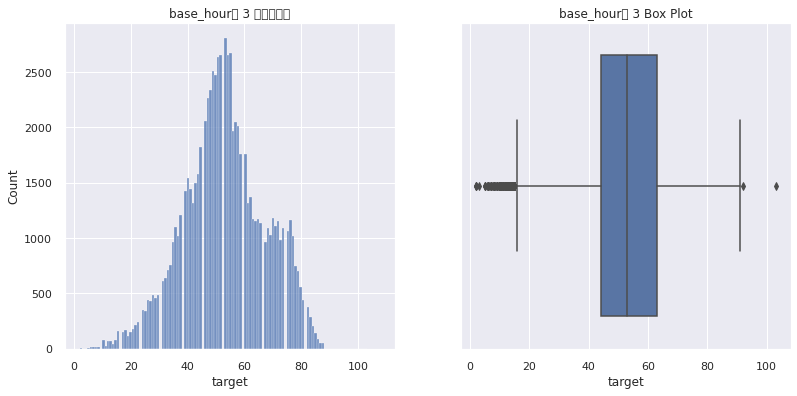

23 데이터 갯수 : 85925


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/back

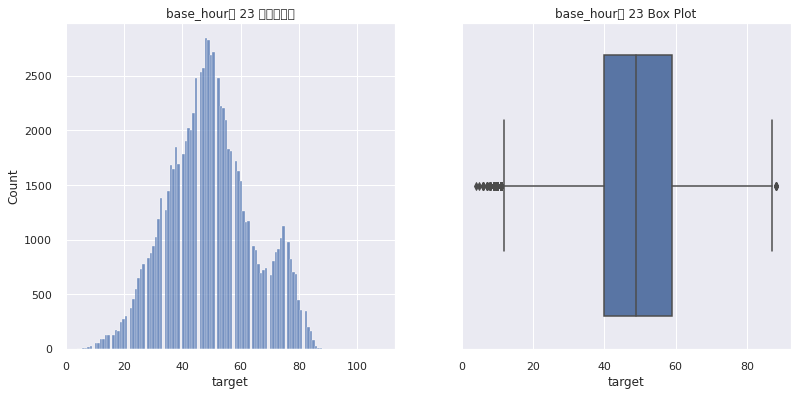

In [ ]:
train_road103=train[train.road_rating==103]
value_hist(train_road103,'base_hour')

- 시간대별 target 분포도

In [ ]:
import mglearn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
#sns.histplot(train.target.loc[train[train['base_hour']<=6].index])

X=train[train['base_hour']<=6][['start_latitude','start_longitude','target']]

kmeans = KMeans(n_clusters=5)
kmeans.fit(X[['target']])
print(silhouette_score(X,kmeans.labels_))
mglearn.discrete_scatter(X['start_longitude'],X['start_latitude'],kmeans.labels_,markers='o',s=3,)
plt.title('before 6am target_count')

ModuleNotFoundError: ignored

In [ ]:
sns.histplot(y.loc[train[(train['base_hour']>6) &(train['base_hour']<=12)].index])
plt.title('before 6am to 12pm target_count')

In [ ]:
sns.histplot(y.loc[train[(train['base_hour']>12) &(train['base_hour']<=18)].index])
plt.title('before 12pm to 18pm target_count')

In [ ]:
sns.histplot(y.loc[train[(train['base_hour']>18) &(train['base_hour']<=24)].index])
plt.title('before 18pm to 24pm target_count')

In [ ]:
train.base_date.describe()

count                 4701217
unique                    281
top       2022-06-03 00:00:00
freq                    20544
first     2021-09-01 00:00:00
last      2022-07-31 00:00:00
Name: base_date, dtype: object

In [ ]:
test.base_date.describe()

count                  291241
unique                     31
top       2022-08-10 00:00:00
freq                     9691
first     2022-08-01 00:00:00
last      2022-08-31 00:00:00
Name: base_date, dtype: object

2022-06-23T00:00:00.000000000 데이터 갯수 : 18781


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/back

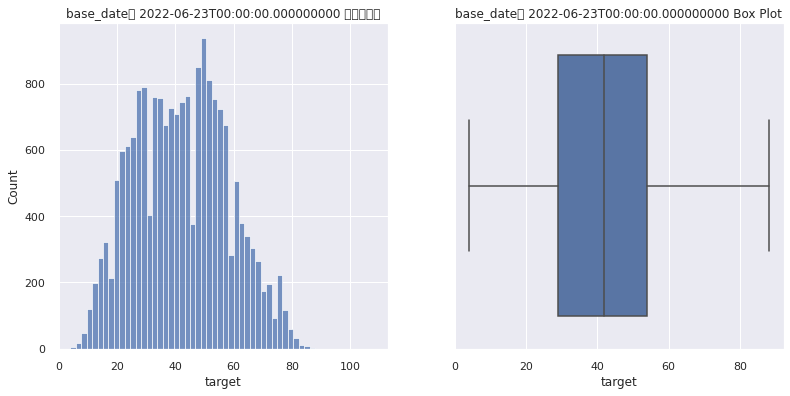

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


2022-07-28T00:00:00.000000000 데이터 갯수 : 7601


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44536 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47016 missing from current font.
  font.set_

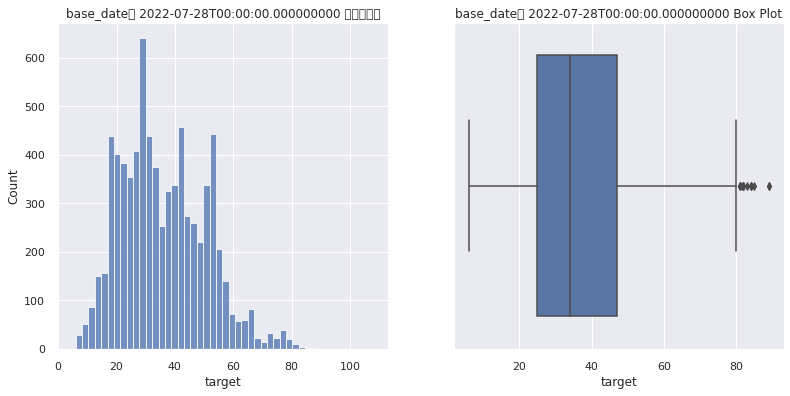

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


2021-10-10T00:00:00.000000000 데이터 갯수 : 18680


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44536 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47016 missing from current font.
  font.set_

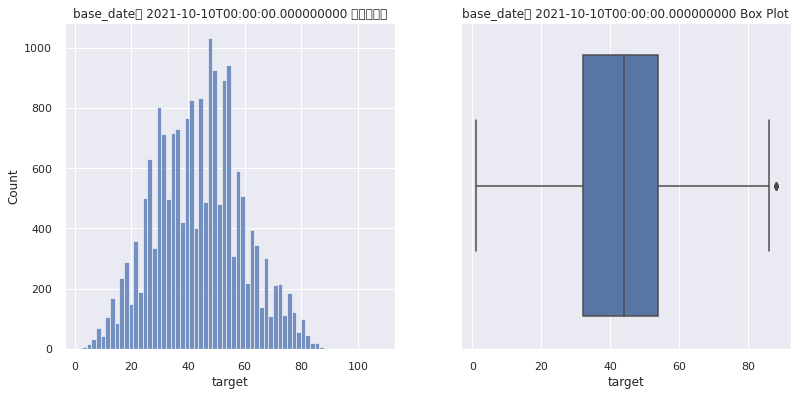

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


2022-03-11T00:00:00.000000000 데이터 갯수 : 14090


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44536 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47016 missing from current font.
  font.set_

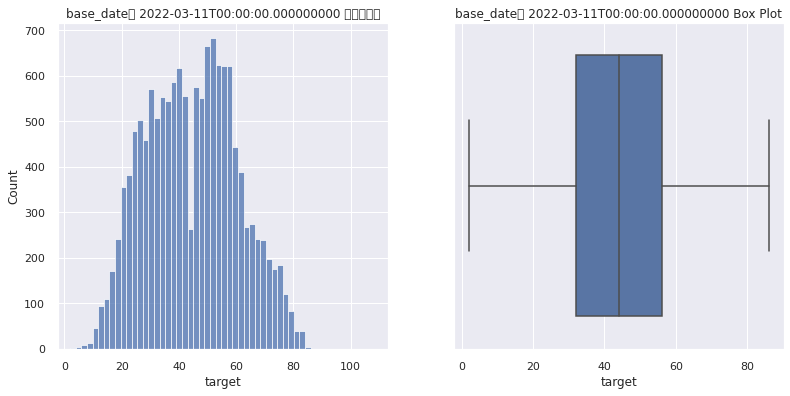

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


2021-10-05T00:00:00.000000000 데이터 갯수 : 19892


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44536 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47016 missing from current font.
  font.set_

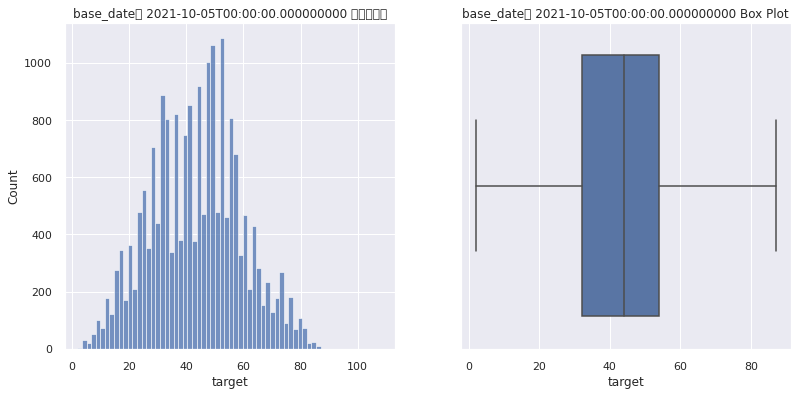

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


2021-09-13T00:00:00.000000000 데이터 갯수 : 19677


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44536 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47016 missing from current font.
  font.set_

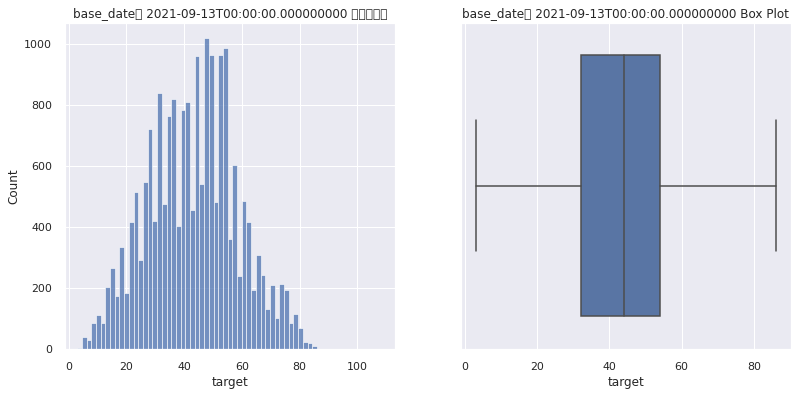

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


2022-01-06T00:00:00.000000000 데이터 갯수 : 6053


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44536 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47016 missing from current font.
  font.set_

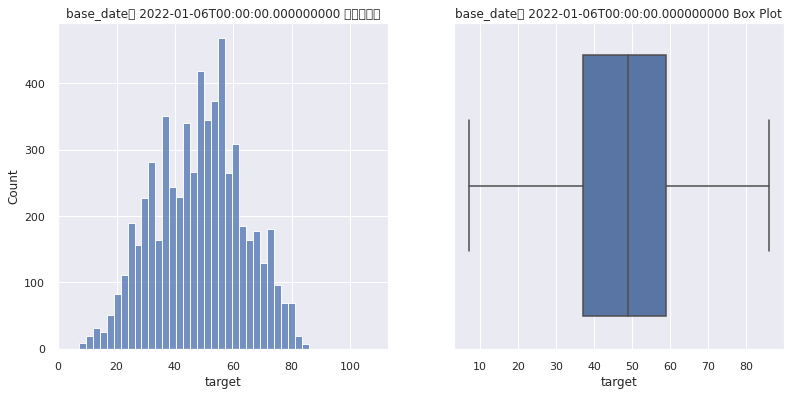

2021-12-13T00:00:00.000000000 데이터 갯수 : 20075


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/back

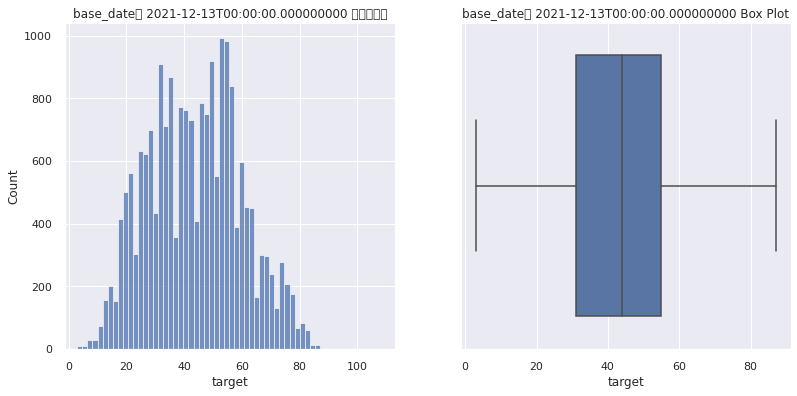

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


2021-10-04T00:00:00.000000000 데이터 갯수 : 18623


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44536 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47016 missing from current font.
  font.set_

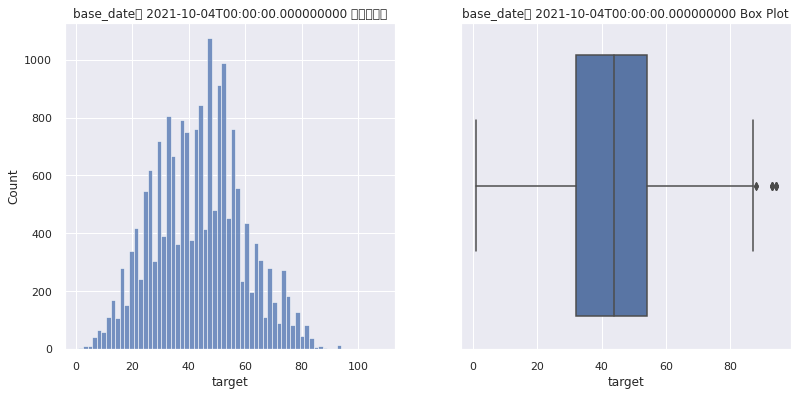

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


2021-12-08T00:00:00.000000000 데이터 갯수 : 20184


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44536 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47016 missing from current font.
  font.set_

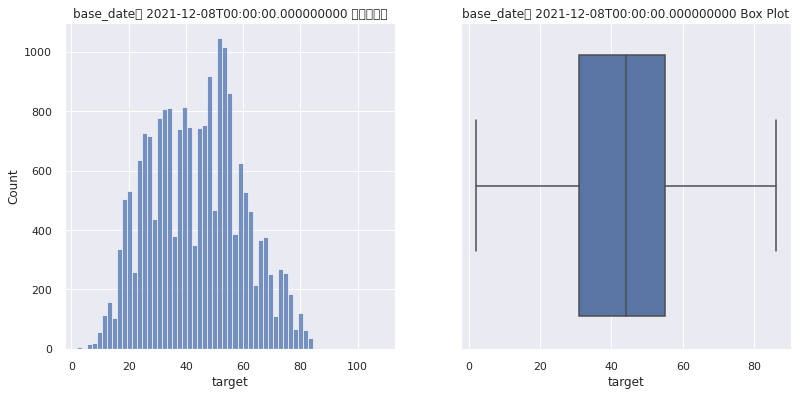

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


2022-07-24T00:00:00.000000000 데이터 갯수 : 9593


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44536 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47016 missing from current font.
  font.set_

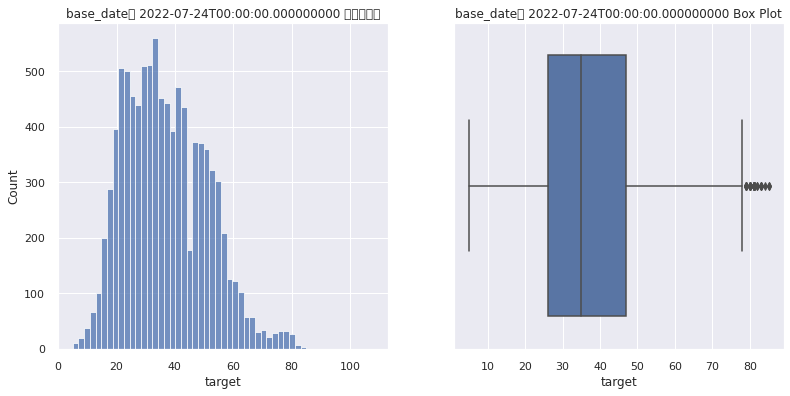

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


2021-12-29T00:00:00.000000000 데이터 갯수 : 20139


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44536 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47016 missing from current font.
  font.set_

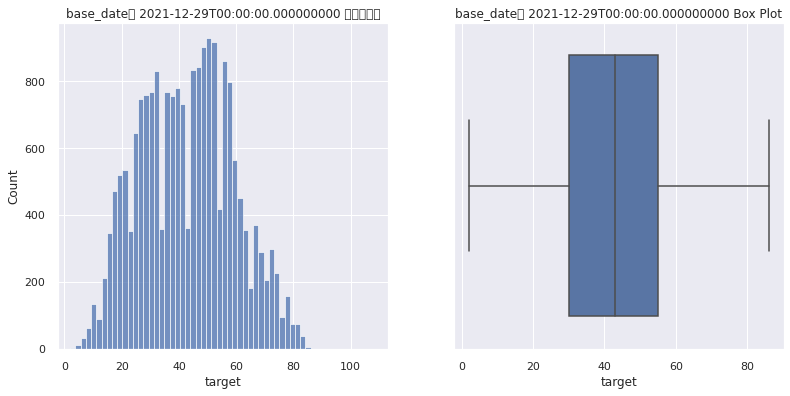

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


2022-05-07T00:00:00.000000000 데이터 갯수 : 18644


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44536 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47016 missing from current font.
  font.set_

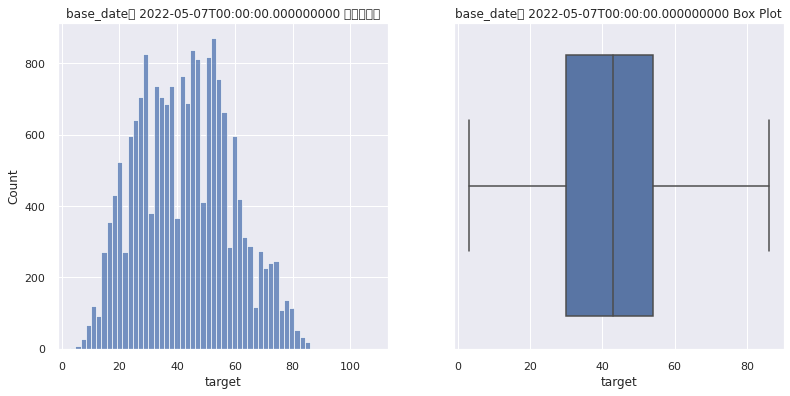

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


2022-02-03T00:00:00.000000000 데이터 갯수 : 20015


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44536 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47016 missing from current font.
  font.set_

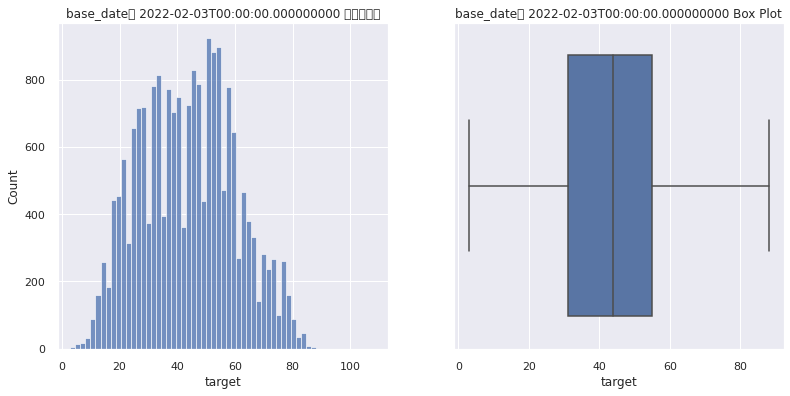

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


2022-05-01T00:00:00.000000000 데이터 갯수 : 18681


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44536 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47016 missing from current font.
  font.set_

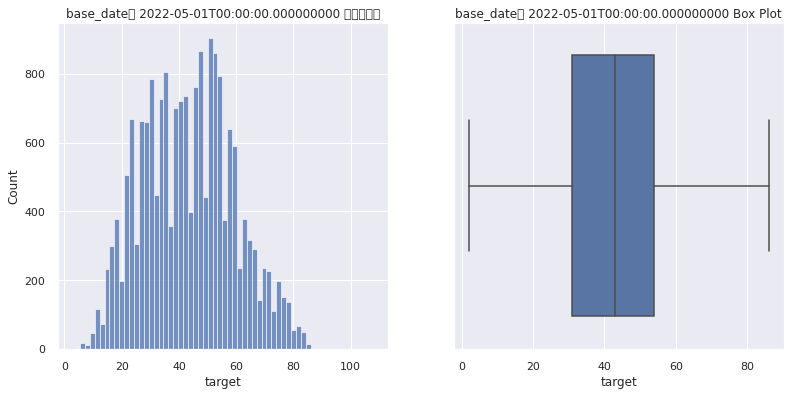

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


2022-07-01T00:00:00.000000000 데이터 갯수 : 9980


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44536 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47016 missing from current font.
  font.set_

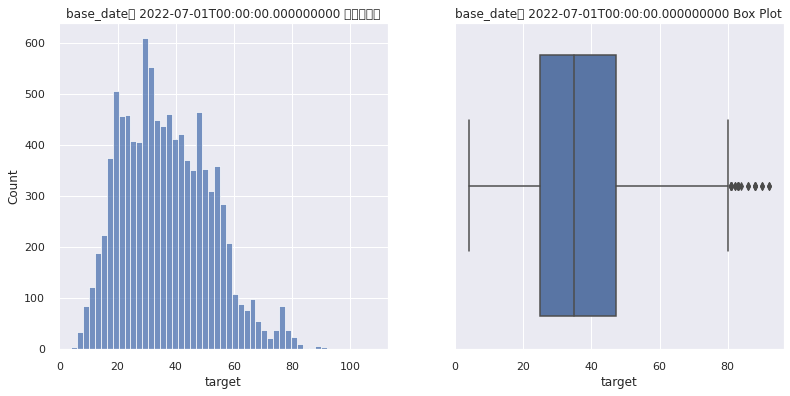

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


2021-10-01T00:00:00.000000000 데이터 갯수 : 19933


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44536 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47016 missing from current font.
  font.set_

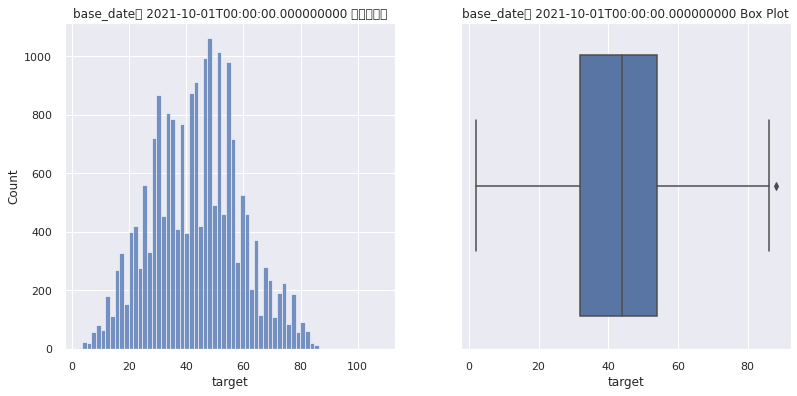

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


2022-03-19T00:00:00.000000000 데이터 갯수 : 15311


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44536 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47016 missing from current font.
  font.set_

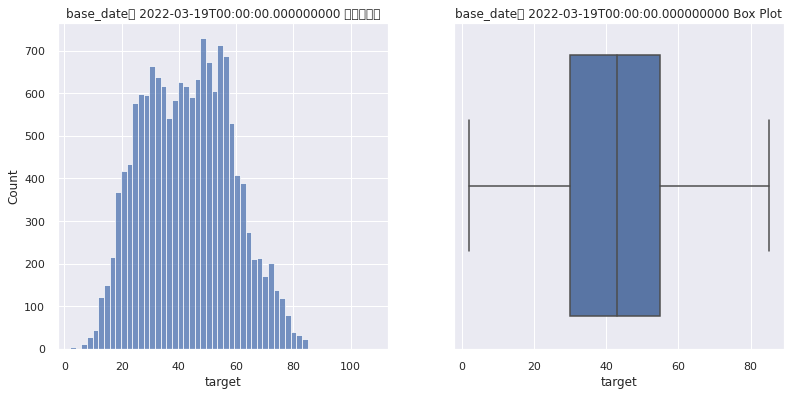

2022-02-10T00:00:00.000000000 데이터 갯수 : 20016


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/back

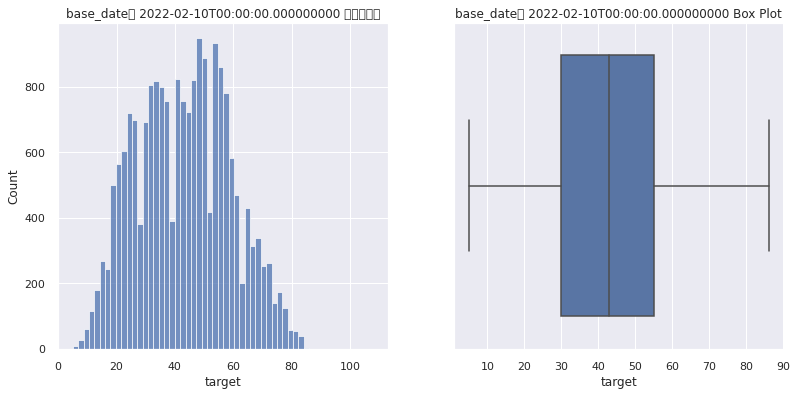

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


2022-01-19T00:00:00.000000000 데이터 갯수 : 20005


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44536 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47016 missing from current font.
  font.set_

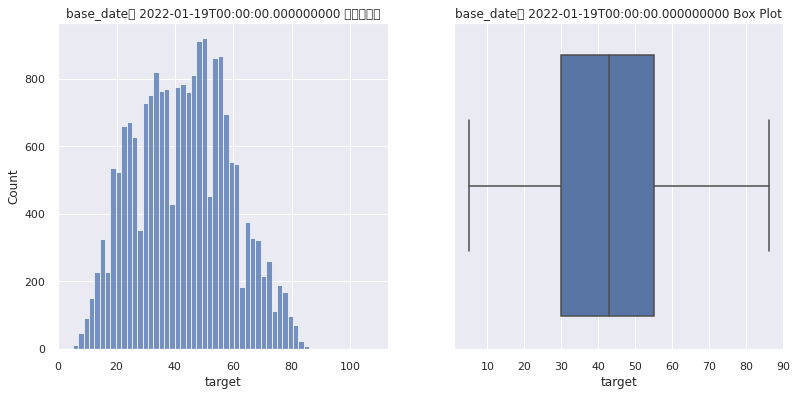

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


2021-09-07T00:00:00.000000000 데이터 갯수 : 19644


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44536 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47016 missing from current font.
  font.set_

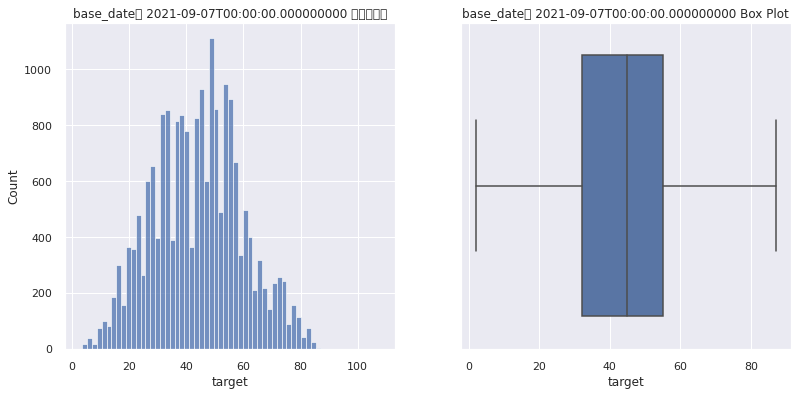

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


2022-02-05T00:00:00.000000000 데이터 갯수 : 20110


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44536 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47016 missing from current font.
  font.set_

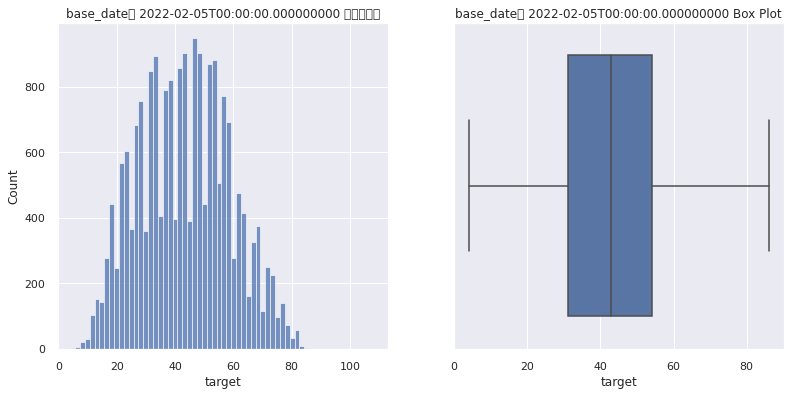

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


2021-09-27T00:00:00.000000000 데이터 갯수 : 18149


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44536 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47016 missing from current font.
  font.set_

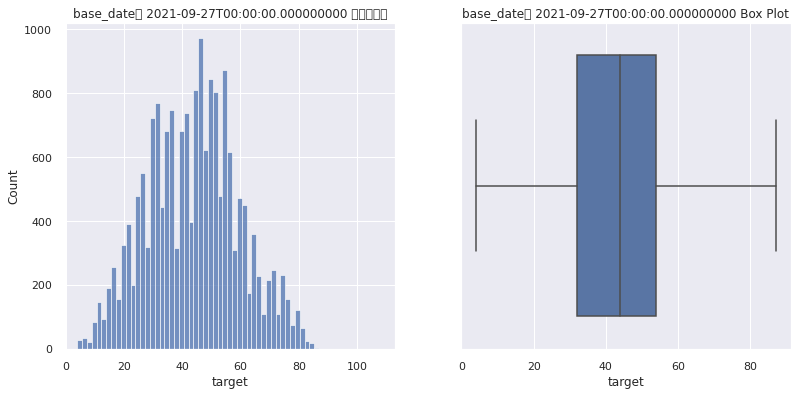

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


2022-01-07T00:00:00.000000000 데이터 갯수 : 20286


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44536 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47016 missing from current font.
  font.set_

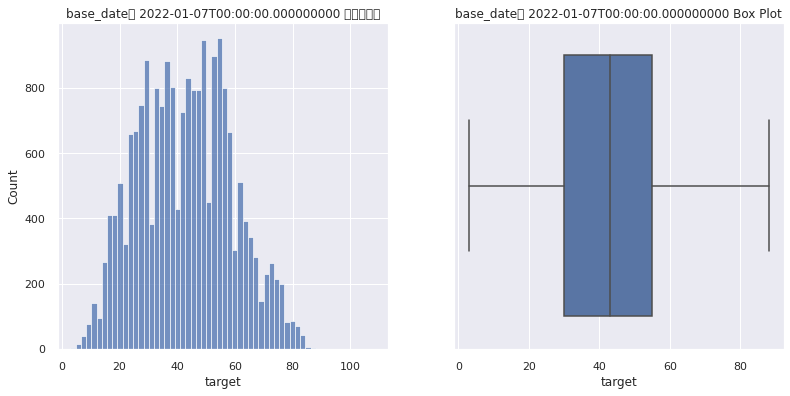

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


2021-09-03T00:00:00.000000000 데이터 갯수 : 19880


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44536 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47016 missing from current font.
  font.set_

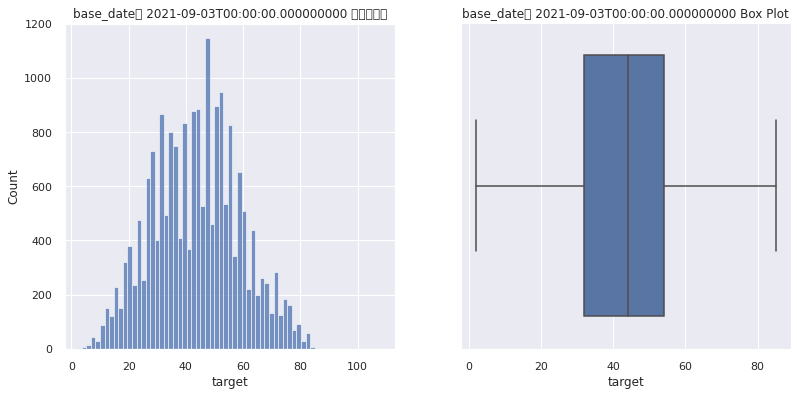

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


2022-01-16T00:00:00.000000000 데이터 갯수 : 20022


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44536 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47016 missing from current font.
  font.set_

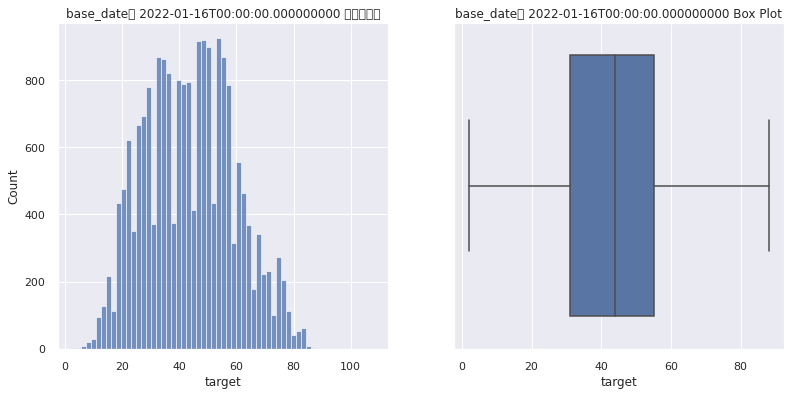

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


2022-06-12T00:00:00.000000000 데이터 갯수 : 11696


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44536 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47016 missing from current font.
  font.set_

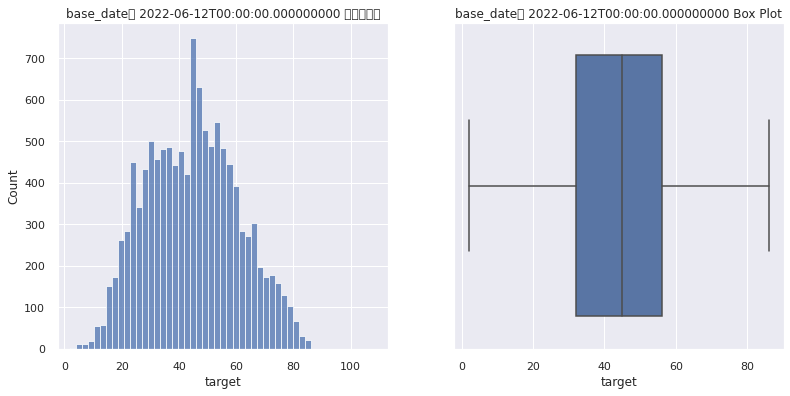

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


2021-09-28T00:00:00.000000000 데이터 갯수 : 19731


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44536 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47016 missing from current font.
  font.set_

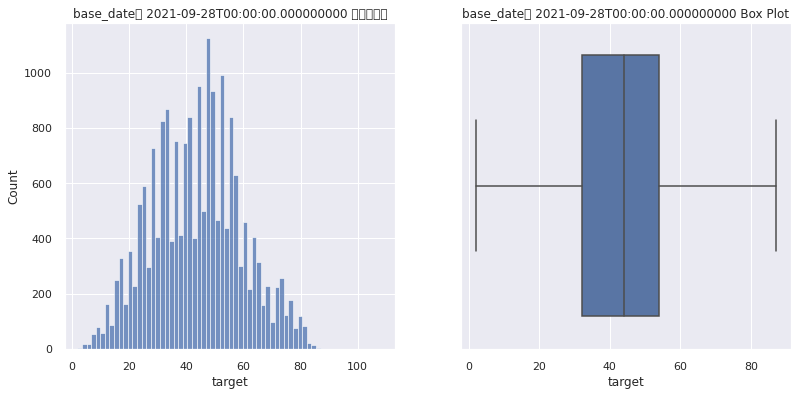

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


2021-10-28T00:00:00.000000000 데이터 갯수 : 19814


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44536 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47016 missing from current font.
  font.set_

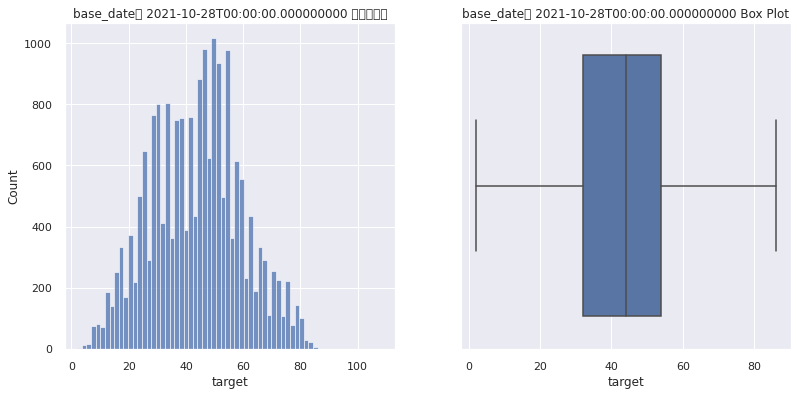

2021-10-18T00:00:00.000000000 데이터 갯수 : 19741


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/back

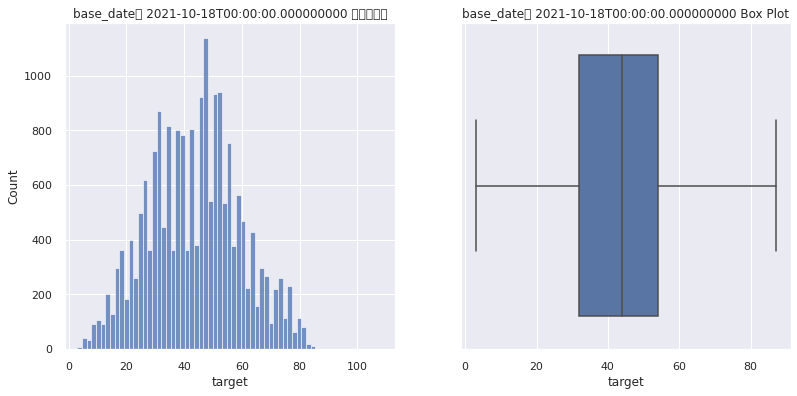

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


2022-05-22T00:00:00.000000000 데이터 갯수 : 16343


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44536 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47016 missing from current font.
  font.set_

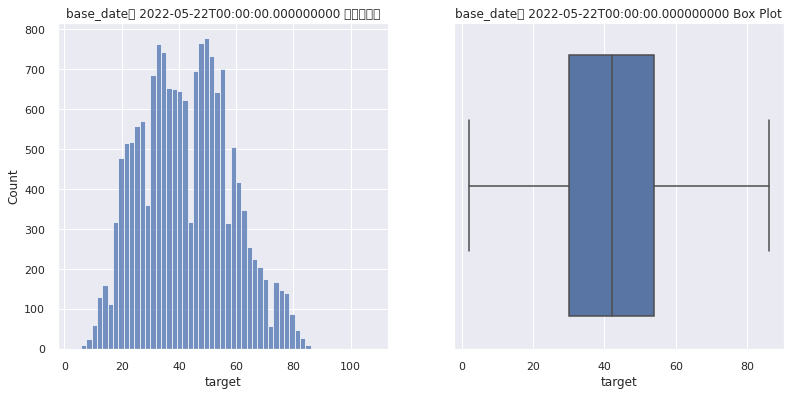

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


2021-12-05T00:00:00.000000000 데이터 갯수 : 19922


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44536 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47016 missing from current font.
  font.set_

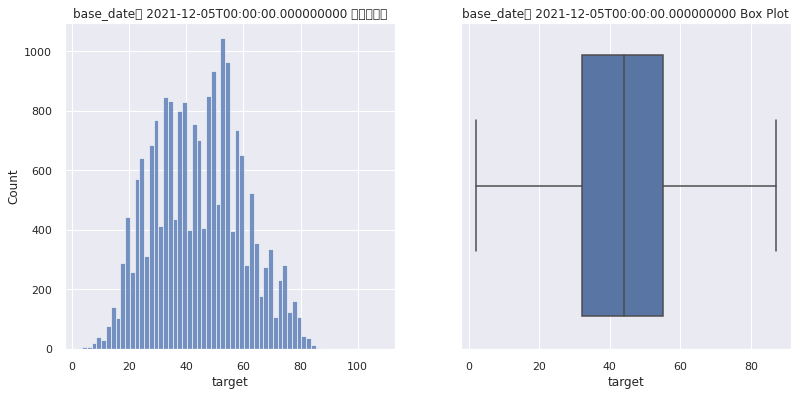

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


2022-05-23T00:00:00.000000000 데이터 갯수 : 10212


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44536 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47016 missing from current font.
  font.set_

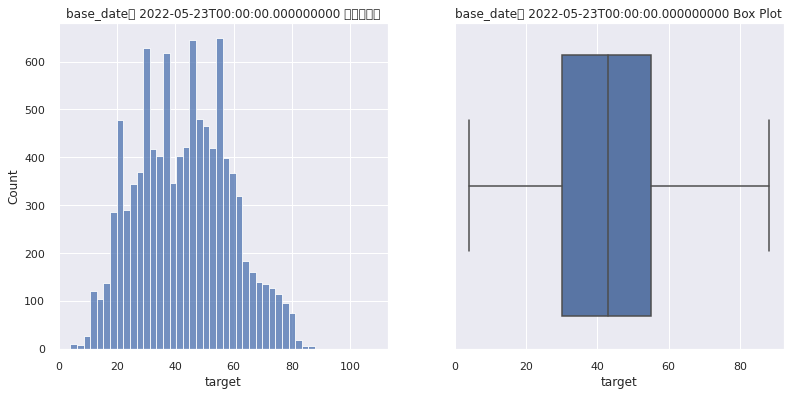

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


2022-05-25T00:00:00.000000000 데이터 갯수 : 19619


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44536 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47016 missing from current font.
  font.set_

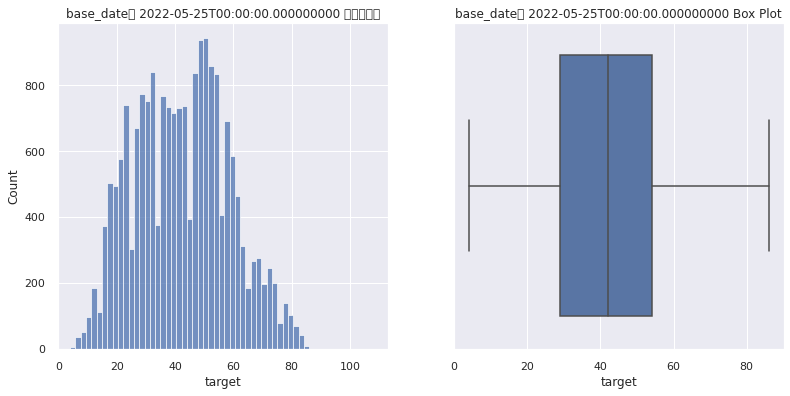

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


2022-07-02T00:00:00.000000000 데이터 갯수 : 9624


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44536 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47016 missing from current font.
  font.set_

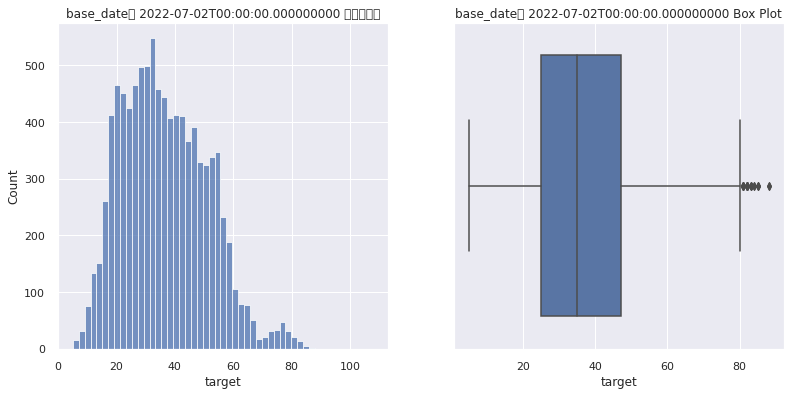

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


2022-06-10T00:00:00.000000000 데이터 갯수 : 17938


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44536 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47016 missing from current font.
  font.set_

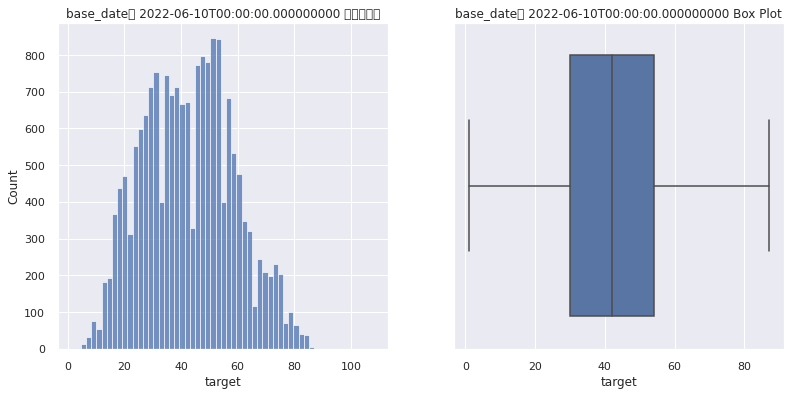

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


2021-09-17T00:00:00.000000000 데이터 갯수 : 16507


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44536 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47016 missing from current font.
  font.set_

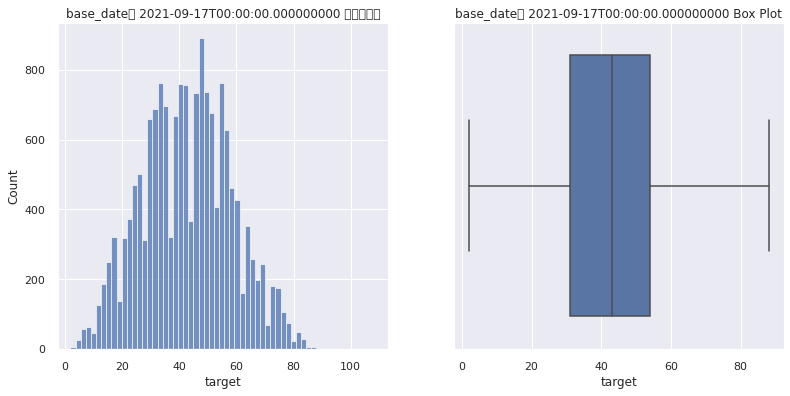

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


2022-02-01T00:00:00.000000000 데이터 갯수 : 17641


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44536 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47016 missing from current font.
  font.set_

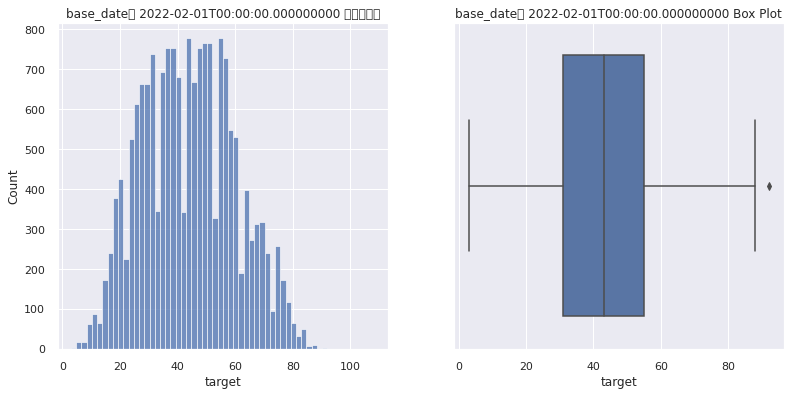

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


2021-10-19T00:00:00.000000000 데이터 갯수 : 18880


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44536 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47016 missing from current font.
  font.set_

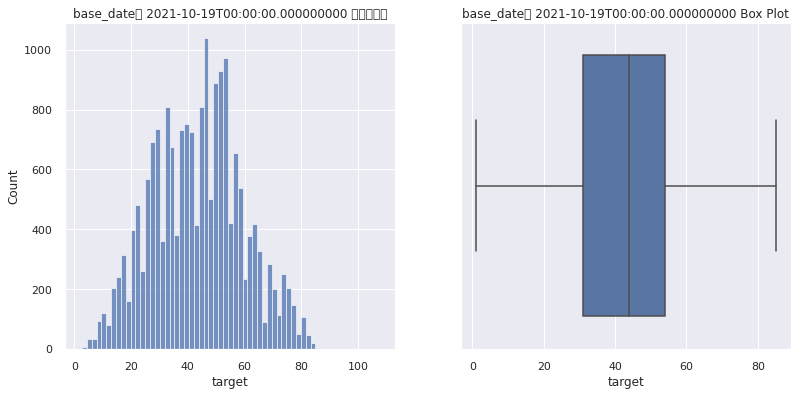

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


2022-03-06T00:00:00.000000000 데이터 갯수 : 19897


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53664 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44536 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47016 missing from current font.
  font.set_

KeyboardInterrupt: ignored

In [ ]:
value_hist(train,'base_date')

In [ ]:
days=train['base_date'].dt.day_of_week
print(days)

0          3
1          3
2          6
3          4
4          1
          ..
4701212    3
4701213    3
4701214    0
4701215    2
4701216    1
Name: base_date, Length: 4701217, dtype: int64


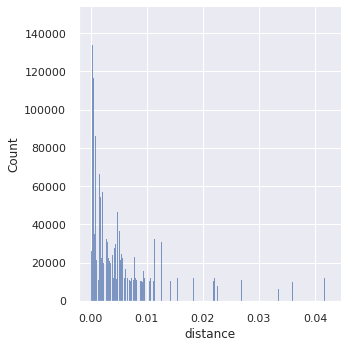

In [ ]:
sns.displot(train.distance)

In [ ]:
train[train.road_name=='-']

,id,base_date,day_of_week,base_hour,road_in_use,lane_count,road_rating,road_name,multi_linked,connect_code,...,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,distance
6,TRAIN_0000006,20220106,목,0,0,2,107,-,0,0,...,가동,33.418412,126.268029,없음,나동,33.414175,126.269378,없음,39.0,0.004446
14,TRAIN_0000014,20220203,목,16,0,1,107,-,0,0,...,송목교,33.316913,126.624634,없음,송목교,33.317065,126.623867,없음,58.0,0.000782
28,TRAIN_0000028,20220612,일,14,0,2,107,-,0,0,...,광평교차로,33.330822,126.354179,없음,금악,33.330673,126.354987,없음,59.0,0.000822
30,TRAIN_0000030,20220623,목,6,0,2,107,-,0,0,...,일호유리,33.472276,126.418443,없음,상귀교차로,33.473390,126.409129,없음,75.0,0.009380
31,TRAIN_0000031,20211028,목,15,0,1,107,-,0,0,...,남수교,33.337244,126.695809,없음,남수교,33.337398,126.696117,없음,36.0,0.000344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701204,TRAIN_4701204,20211001,금,19,0,1,107,-,0,0,...,한남교차로,33.325096,126.665698,없음,서중2교,33.331742,126.676431,없음,55.0,0.012624
4701205,TRAIN_4701205,20220112,수,19,0,1,107,-,0,0,...,감귤창고,33.450215,126.920771,없음,수협,33.448689,126.916358,없음,23.0,0.004670
4701208,TRAIN_4701208,20220323,수,19,0,2,107,-,0,0,...,제2태흥교,33.287356,126.736525,없음,제2태흥교,33.287582,126.737512,없음,61.0,0.001012
4701212,TRAIN_4701212,20211104,목,16,0,1,107,-,0,0,...,대림사거리,33.422145,126.278125,없음,금덕해운,33.420955,126.273750,없음,20.0,0.004533


#시작위경도를 train의 target값 별 분포를 통해 군집 개수를 정하기.

In [ ]:
!pip install mglearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install --upgrade joblib==1.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 306 kB 5.1 MB/s 
  Attempting uninstall: joblib
    Found existing installation: joblib 1.2.0
    Uninstalling joblib-1.2.0:
      Successfully uninstalled joblib-1.2.0


In [ ]:
#import mglearn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
temp=train.groupby(['start_latitude','start_longitude','end_latitude','end_longitude','road_rating'])[['target']].median().reset_index()

X=train[['start_latitude','start_longitude','end_latitude','end_longitude','road_rating','target']]

kmeans = KMeans(n_clusters=5,random_state=5)
kmeans.fit(X)
print(silhouette_score(X,kmeans.labels_))
#mglearn.discrete_scatter(temp['start_longitude'],temp['start_latitude'],kmeans.labels_,markers='o',s=3,)
#mglearn.discrete_scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],[0,1,2,3,4],markers='^',markeredgewidth=2)
plt.legend()
plt.xlabel('latitude')
plt.ylabel('longitude')


KeyboardInterrupt: ignored

In [ ]:
temp.shape

(906, 7)

In [ ]:
temp['c_label']=kmeans.labels_

In [ ]:
temp[temp['c_label']==2]['target'].mean()

23.18324607329843

In [ ]:
train['c_label']=0

In [ ]:
test['c_label']=0

In [ ]:
test.c_label.nunique()

47

In [ ]:
temp.road_type.unique()

array([0, 3])

In [ ]:
train.maximum_speed_limit

In [ ]:
train.start_latitude.nunique()

586

In [ ]:
temp1=test.groupby(['start_latitude','start_longitude','end_latitude','end_longitude','road_name','road_type','road_rating','distance']).size().reset_index(name='freq')
temp1

temp1.to_csv('/content/drive/MyDrive/DACON_Dataset/JEJU_Traffic/open.zip (Unzipped Files)/test_val.csv')

In [ ]:
temp.c_label.nunique()

5

In [ ]:
temp1=test.groupby(['start_latitude','start_longitude']).size().reset_index(name='freq')
temp1.freq()



,start_latitude,start_longitude,freq
0,33.243432,126.422025,693
1,33.244601,126.562080,715
2,33.244871,126.564407,1419
3,33.244882,126.419089,1358
4,33.245150,126.565256,1420
...,...,...,...
289,33.521098,126.585400,1457
290,33.521264,126.581398,726
291,33.521323,126.578404,733
292,33.521329,126.578036,1462


In [ ]:
import folium

jeju_map = folium.Map(location=[33.2434317486804,126.422025484805], zoom_start=6)

df_cities = pd.DataFrame({'시작위도':temp.start_latitude, '시작경도':temp.start_longitude,'도착위도':temp.end_latitude, '도착경도':temp.end_longitude,'도로rating' : temp.road_rating,'도로등급': temp.road_type})

df_cities

,시작위도,시작경도,도착위도,도착경도,도로rating,도로등급
0,33.243432,126.422025,33.244882,126.419089,107,0
1,33.244512,126.427069,33.249505,126.430787,103,0
2,33.244601,126.562080,33.244871,126.564407,107,0
3,33.244601,126.562080,33.247607,126.561943,107,0
4,33.244871,126.564407,33.244601,126.562080,107,0
...,...,...,...,...,...,...
901,33.553525,126.739714,33.554302,126.738379,103,0
902,33.554302,126.738379,33.553525,126.739714,103,0
903,33.554302,126.738379,33.555316,126.736681,103,0
904,33.555316,126.736681,33.554302,126.738379,103,0


In [ ]:
for i in range(len(df_cities)):
    folium.Marker([df_cities.iloc[i][0], df_cities.iloc[i][1]], popup=[df_cities.index[i],df_cities.iloc[i][4]],icon=folium.Icon(color='blue')).add_to(jeju_map)
    folium.Marker([df_cities.iloc[i][2], df_cities.iloc[i][3]], popup=[df_cities.index[i],df_cities.iloc[i][4]],icon=folium.Icon(color='red')).add_to(jeju_map)


In [ ]:
jeju_map.save('jeju.html')

In [ ]:
train.connect_code.unique()

array([  0, 103])

#필요없는 열 삭제.

In [ ]:
print('train최소',train.base_date.min())
print('train최대',train.base_date.max())

print('test최소',test.base_date.min())
print('test최대',test.base_date.max())


train최소 2021-09-01 00:00:00
train최대 2022-07-31 00:00:00
test최소 2022-08-01 00:00:00
test최대 2022-08-31 00:00:00


In [ ]:
train

,id,base_date,day_of_week,base_hour,road_in_use,lane_count,road_rating,road_name,multi_linked,connect_code,...,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,distance
0,TRAIN_0000000,20220623,목,17,0,1,106,지방도1112호선,0,0,...,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0,0.000277
1,TRAIN_0000001,20220728,목,21,0,2,103,일반국도11호선,0,0,...,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0,0.004987
2,TRAIN_0000002,20211010,일,7,0,2,103,일반국도16호선,0,0,...,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0,0.006516
3,TRAIN_0000003,20220311,금,13,0,2,107,태평로,0,0,...,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0,0.001104
4,TRAIN_0000004,20211005,화,8,0,2,103,일반국도12호선,0,0,...,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0,0.003630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701212,TRAIN_4701212,20211104,목,16,0,1,107,-,0,0,...,대림사거리,33.422145,126.278125,없음,금덕해운,33.420955,126.273750,없음,20.0,0.004533
4701213,TRAIN_4701213,20220331,목,2,0,2,107,-,0,0,...,광삼교,33.472505,126.424368,없음,광삼교,33.472525,126.424890,없음,65.0,0.000522
4701214,TRAIN_4701214,20220613,월,22,0,2,103,일반국도12호선,0,0,...,고성교차로,33.447183,126.912579,없음,성산교차로,33.444121,126.912948,없음,30.0,0.003084
4701215,TRAIN_4701215,20211020,수,2,0,2,103,일반국도95호선,0,0,...,제6광령교,33.443596,126.431817,없음,관광대학입구,33.444996,126.433332,없음,73.0,0.002063


In [ ]:
train['base_date']= pd.to_datetime(train['base_date'],format='%Y%m%d')
#datetime 형식으로 변경 train

In [ ]:
test['base_date']= pd.to_datetime(test['base_date'],format='%Y%m%d')
#datetime 형식으로 변경 test

In [ ]:
train['year']=train['base_date'].dt.year
train['month']=train['base_date'].dt.month
train['day']=train['base_date'].dt.day
# 날짜를 연 월 일로 분리.
#train=train.drop(['base_date'],axis=1)
# base_date컬럼삭제.


In [ ]:
test['year']=test['base_date'].dt.year
test['month']=test['base_date'].dt.month
test['day']=test['base_date'].dt.day
# test도 동일하게 적용.
#test=test.drop(['base_date'],axis=1)


In [ ]:
train=train.drop(['base_date'],axis=1)

In [ ]:
test=test.drop(['base_date'],axis=1)

In [ ]:
test.head()

,id,base_date,day_of_week,base_hour,road_in_use,lane_count,road_rating,road_name,multi_linked,connect_code,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,distance
0,TEST_000000,20220825,목,17,0,3,107,연삼로,0,0,...,0,산지2교,33.499427,126.541298,없음,제주은행사거리,33.500772,126.543837,있음,0.002873
1,TEST_000001,20220809,화,12,0,2,103,일반국도12호선,0,0,...,3,중문입구,33.258507,126.427003,없음,관광단지입구,33.258119,126.415840,없음,0.011171
2,TEST_000002,20220805,금,2,0,1,103,일반국도16호선,0,0,...,0,도순3교,33.258960,126.476508,없음,도순2교,33.259206,126.474687,없음,0.001837
3,TEST_000003,20220818,목,23,0,3,103,일반국도11호선,0,0,...,0,아라주공아파트,33.473494,126.545647,없음,인다마을,33.471061,126.545467,없음,0.002440
4,TEST_000004,20220810,수,17,0,3,106,번영로,0,0,...,0,부록교 시종점,33.501477,126.569223,없음,봉개교 시종점,33.496863,126.581230,없음,0.012863


# 시작위경도와 도착위경도의 유클라디안 거리를 구해 새로운 컬럼으로 설정하기.

In [ ]:
import math

def euc_dist(df):
  df['distance']=(((df['end_latitude']-df['start_latitude'])**2)+((df['end_longitude']-df['start_longitude'])**2))**(1/2)

euc_dist(train)
euc_dist(test)



In [ ]:
train['peak_c']=0
test['peak_c']=0

In [ ]:
train[train.base_hour.between(5,7)].base_hour.unique()

array([7, 6, 5])

In [ ]:
train['peak_c'][train[train.base_hour.between( 5 , 6)].index]=1
test['peak_c'][test[test.base_hour.between( 5 , 6)].index]=1

train['peak_c'][train[train.base_hour.between( 18 , 0)].index]=1
test['peak_c'][test[test.base_hour.between( 18 , 0)].index]=1


train['peak_c'][train[train.base_hour.between( 1 , 4)].index]=2
test['peak_c'][test[test.base_hour.between( 1 , 4)].index]=2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3

In [ ]:
test.peak_c.unique()

array([0, 2, 1])

# 휴일 및 공휴일 컬럼생성하기.

In [ ]:
t21_off = ['2021-09-20','2021-09-21','2021-09-22','2022-01-01','2022-01-29','2022-01-30','2022-01-31','2022-02-01',
'2022-02-02','2022-03-01','2022-03-09','2022-05-05','2022-05-09','2022-06-01',
'2022-06-06']

test_t22_off = ['2022-08-06','2022-08-07','2022-08-13','2022-08-14','2022-08-15'
,'2022-08-20','2022-08-21','2022-08-27']

train['off_day']=0
test['off_day']=0

In [ ]:
for i in t21_off:
  dtt=pd.to_datetime(i,format='%Y-%m-%d')
  year =dtt.year
  month = dtt.month
  day = dtt.day
  v= (train['year']==year)&(train['month']==month)&(train['day']==day)
  train.loc[v,'off_day'] = 1


for i in test_t22_off :
  dtt=pd.to_datetime(i,format='%Y-%m-%d')
  year =dtt.year
  month = dtt.month
  day = dtt.day
  v= (test['year']==year)&(test['month']==month)&(test['day']==day)

  test.loc[v,'off_day'] = 1





   

# 도로 만들기

In [ ]:
train.end_latitude.nunique()

586

In [ ]:
temp=train.groupby(['start_latitude','start_longitude','end_latitude','end_longitude']).size().reset_index(name='freq')



In [ ]:
temp['avg_lat']= (temp['start_latitude']+temp['end_latitude'])/2.0
temp['avg_long']= (temp['start_longitude']+temp['end_longitude'])/2.0


In [ ]:
temp

,start_latitude,start_longitude,end_latitude,end_longitude,freq,avg_lat,avg_long
0,33.243432,126.422025,33.244882,126.419089,5528,33.244157,126.420557
1,33.244512,126.427069,33.249505,126.430787,4213,33.247008,126.428928
2,33.244601,126.562080,33.244871,126.564407,5879,33.244736,126.563244
3,33.244601,126.562080,33.247607,126.561943,5206,33.246104,126.562012
4,33.244871,126.564407,33.244601,126.562080,5937,33.244736,126.563244
...,...,...,...,...,...,...,...
899,33.553525,126.739714,33.554302,126.738379,5267,33.553913,126.739047
900,33.554302,126.738379,33.553525,126.739714,5298,33.553913,126.739047
901,33.554302,126.738379,33.555316,126.736681,5308,33.554809,126.737530
902,33.555316,126.736681,33.554302,126.738379,5306,33.554809,126.737530


In [ ]:
train[train['target']<10]

,id,day_of_week,base_hour,road_in_use,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,c_label,year,month,day,distance
212,TRAIN_0000212,금,18,0,1,107,중정로,0,0,50.0,...,정방수퍼,33.248633,126.567766,없음,9.0,32,2021,12,31,0.001680
333,TRAIN_0000333,화,12,0,3,103,일반국도12호선,0,0,70.0,...,중앙로타리,33.253200,126.561049,없음,7.0,116,2022,1,4,0.004528
906,TRAIN_0000906,토,13,0,3,103,일반국도16호선,0,0,70.0,...,노형오거리,33.486000,126.479550,없음,6.0,734,2021,9,4,0.000683
1191,TRAIN_0001191,화,18,0,3,103,일반국도16호선,0,0,70.0,...,신광사거리,33.493793,126.492189,있음,9.0,758,2021,10,5,0.002429
1192,TRAIN_0001192,수,18,0,2,103,일반국도12호선,0,0,50.0,...,미수2교,33.483661,126.405096,없음,6.0,718,2021,12,29,0.000970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4700492,TRAIN_4700492,화,16,0,3,103,일반국도16호선,0,0,70.0,...,한라대학입구,33.480679,126.472216,있음,8.0,699,2021,10,12,0.004792
4700505,TRAIN_4700505,토,17,0,2,103,일반국도12호선,0,0,50.0,...,미수2교,33.483661,126.405096,없음,9.0,718,2022,3,5,0.000970
4700632,TRAIN_4700632,목,9,0,2,107,동홍로,0,0,50.0,...,동홍사거리,33.254628,126.567678,없음,9.0,155,2022,5,26,0.001959
4700829,TRAIN_4700829,일,14,0,3,103,일반국도16호선,0,0,70.0,...,노형오거리,33.486000,126.479550,없음,9.0,734,2021,9,19,0.000683


In [ ]:
train['c_label']=0
test['c_label']=0

In [ ]:
temp

,start_latitude,start_longitude,end_latitude,end_longitude,road_rating,target,c_label
0,33.243432,126.422025,33.244882,126.419089,107,38.0,1
1,33.244512,126.427069,33.249505,126.430787,103,41.0,3
2,33.244601,126.562080,33.244871,126.564407,107,25.0,2
3,33.244601,126.562080,33.247607,126.561943,107,26.0,2
4,33.244871,126.564407,33.244601,126.562080,107,20.0,2
...,...,...,...,...,...,...,...
901,33.553525,126.739714,33.554302,126.738379,103,40.0,3
902,33.554302,126.738379,33.553525,126.739714,103,55.0,0
903,33.554302,126.738379,33.555316,126.736681,103,43.0,3
904,33.555316,126.736681,33.554302,126.738379,103,36.0,1


In [ ]:
#train['c_label'][train[train['weight_restricted']==32400.].index]=1


for sla,slo,ela,elo,label in zip(temp['start_latitude'],temp['start_longitude'],temp['end_latitude'],temp['end_longitude'],temp['c_label']) :
  temper = label
  train['c_label'][train[ ((train['start_latitude']==sla) & (train['start_longitude']==slo) & (train['end_latitude']==ela )&(train['end_longitude']==elo)) ].index]=temper
  test['c_label'][test[ ((test['start_latitude']==sla) & (test['start_longitude']==slo) & (test['end_latitude']==ela )&(test['end_longitude']==elo)) ].index]=temper
#46sec
  


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
train.c_label.nunique()

1

In [ ]:
train.road_num.max()

903

# Preprocessing

# Labeling

In [ ]:
cate_val = ['day_of_week','start_turn_restricted','end_turn_restricted']
for i in cate_val :
  enc = LabelEncoder()
  enc=enc.fit(train[i])
  train[i]=enc.transform(train[i])
  for label in np.unique(test[i]):
        if label not in enc.classes_: 
            enc.classes_ = np.append(enc.classes_, label)
  test[i]=enc.transform(test[i]) # data leakage 주의
# 한글로 되어있는 열 라벨링

In [ ]:
train.dtypes


id                        object
day_of_week                int64
base_hour                  int64
road_in_use                int64
lane_count                 int64
road_rating                int64
road_name                 object
multi_linked               int64
connect_code               int64
maximum_speed_limit      float64
vehicle_restricted       float64
weight_restricted        float64
height_restricted        float64
road_type                  int64
start_node_name           object
start_latitude           float64
start_longitude          float64
start_turn_restricted      int64
end_node_name             object
end_latitude             float64
end_longitude            float64
end_turn_restricted        int64
target                   float64
year                       int64
month                      int64
day                        int64
distance                 float64
peak_c                     int64
dtype: object

In [ ]:
train=train.drop(['base_hour'],axis=1)
test=test.drop(['base_hour'],axis=1)

----------------------------------------------------

# Try 1 Day를 살리고, 요일컬럼을 삭제.

In [ ]:
train=train.drop(['day_of_week'],axis=1)
test=test.drop(['day_of_week'],axis=1)

# Try 2 도착 위경도 데이터만을 이용하여 예측
근거 : 시작위도 경도 값은 도착 위경도 값이랑 상관관계가 높아 과적합의 가능성?

In [ ]:
train=train.drop(['start_latitude','start_longitude'],axis=1)
test=test.drop(['start_latitude','start_longitude'],axis=1)

In [ ]:
from sklearn.preprocessing import QuantileTransformer, StandardScaler

min_max = ['end_latitude','end_longitude']
train_num = train[min_max].copy()

test_num = test[min_max].copy()


scaler=QuantileTransformer(n_quantiles=900)

scaler.fit(train_num)

train_num[min_max]=scaler.transform(train_num[min_max])



test_num[min_max]=scaler.transform(test_num[min_max]) # leakage 주의


train[min_max] = train_num[min_max]
test[min_max] = test_num[min_max]  

# 데이터 분리.

In [ ]:
from sklearn.model_selection import train_test_split
y=train['target']
# target분리.
train=train.drop(['id','vehicle_restricted','height_restricted','road_name', 'start_node_name', 'end_node_name','road_in_use'],axis=1)
# 학습에 필요없는 문자열, 인덱스 , 모든행이 0인컬럼. target 삭제.
#x_train , x_valid , y_train, y_valid = train_test_split(train,y,test_size=0.2,random_state=5)
# target열이 섞여있어, 임의로 뒤에 20프로 검증세트로 사용. -> test셋을 예측하는 것이므로, 일반화 성능을 확인할 방법이 ㅇ벗음.
# 모델의 일반화 성능이 검증되면(하이퍼파라미터), 전체세트로 사용해야함.


In [ ]:
train=train.drop('target',axis=1)

In [ ]:
train=train.drop(['day'],axis=1)

In [ ]:
train.shape

(4701217, 18)

In [ ]:
#train=train.drop(['year'],axis=1)

In [ ]:
test.day.nunique()

31

In [ ]:
# test셋에서도 동일하게 하기.
test=test.drop(['id','vehicle_restricted','height_restricted','road_name','road_in_use', 'start_node_name', 'end_node_name'],axis=1)
#test=test.drop(['year'],axis=1)
test.shape

(291241, 19)

In [ ]:
test=test.drop(['day'],axis=1)

In [ ]:
#test=test.drop(['year'],axis=1)

In [ ]:
test

,day_of_week,lane_count,multi_linked,connect_code,maximum_speed_limit,weight_restricted,road_type,start_latitude,start_longitude,start_turn_restricted,end_latitude,end_longitude,end_turn_restricted,year,month,distance,peak_c
0,1,3,0,0,70.0,0.0,0,0.873592,0.586984,0,0.892365,0.600751,1,2022,8,0.002873,0
1,6,2,0,0,70.0,0.0,3,0.194618,0.265957,0,0.197747,0.237171,0,2022,8,0.011171,0
2,0,1,0,0,60.0,0.0,0,0.201502,0.372340,0,0.209637,0.371089,0,2022,8,0.001837,2
3,1,3,0,0,70.0,0.0,0,0.729036,0.603880,0,0.712140,0.603880,0,2022,8,0.002440,0
4,2,3,0,0,70.0,0.0,0,0.895494,0.720275,0,0.861702,0.745307,0,2022,8,0.012863,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291236,5,1,0,0,80.0,0.0,0,0.725282,0.356070,0,0.707134,0.355444,0,2022,8,0.003197,1
291237,0,2,0,0,60.0,0.0,0,0.338548,0.767835,0,0.339174,0.772841,0,2022,8,0.004778,0
291238,0,1,0,0,30.0,0.0,0,0.836045,0.430538,1,0.866083,0.434293,1,2022,8,0.003880,0
291239,0,2,0,0,60.0,0.0,0,0.149562,0.453692,0,0.171464,0.460576,0,2022,8,0.000933,0


---------------------------------------------------------

# Outlier -> IQR # 했을 떄 성능이 낮아짐.

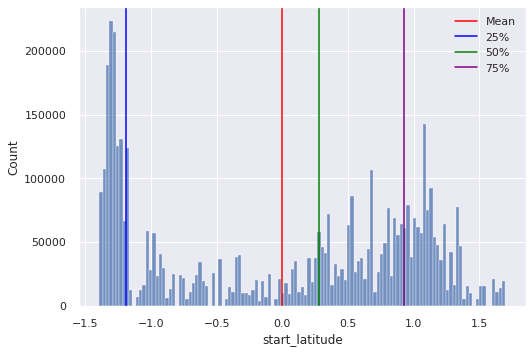

In [ ]:
def draw_line(plt,col):
  mean= train.describe().loc['mean',col]
  m25 = train.describe().loc['25%',col]
  m50 = train.describe().loc['50%',col]
  m75 = train.describe().loc['75%',col]

  plt.axvline(mean,color='red')
  plt.axvline(m25,color='blue')
  plt.axvline(m50,color='green')
  plt.axvline(m75,color='purple')

  plt.legend(['Mean','25%','50%','75%'])

pp=sns.histplot(train['start_latitude'])
draw_line(pp,'start_latitude')

In [ ]:
train.head(4)

,id,day_of_week,base_hour,road_in_use,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,year,month,day
0,TRAIN_0000000,1,17,0,1,106,지방도1112호선,0,0,60.0,...,126.662612,0,제3교래교,33.427749,126.662335,0,52.0,2022,6,23
1,TRAIN_0000001,1,21,0,2,103,일반국도11호선,0,0,60.0,...,126.529107,1,KAL사거리,33.504811,126.526240,0,30.0,2022,7,28
2,TRAIN_0000002,4,7,0,2,103,일반국도16호선,0,0,80.0,...,126.368598,0,상창육교,33.280072,126.362147,0,61.0,2021,10,10
3,TRAIN_0000003,0,13,0,2,107,태평로,0,0,50.0,...,126.567204,0,서현주택,33.245565,126.566228,0,20.0,2022,3,11


In [ ]:
# base_hour와 target과의 상관관계가 낮아서, 각 시간별 분포에서 outlier를 삭제.
def outlier_proc(train,col):

  df_train=train.copy()

  print('outlier잡기전 : ',df_train.shape)
  for i in train[col].unique():
    df = df_train[df_train[col]==i]
    q1,q3 = np.percentile(df['target'],[25,75])

    print(i,'시',q1, q3)
    iqr = q3 -q1
    print('저점',(q1-(iqr*1.5)))
    print('고점',(q3+(iqr*1.5)))
    low=(q1-(iqr*1.5))
    high=(q3+(iqr*1.5))
    if low <=0 :
      train=train.drop(index=df[df['target']>high].index)
    else :
      train=train.drop(index=df[df['target']<low].index)
      train=train.drop(index=df[df['target']>high].index)
  print('outlier잡은후 : ',train.shape)
  return train

train=outlier_proc(train,'base_hour')
    
''''condition1 = df['target']<(q1-(iqr*1.5))
  
print('lower_bound : ', condition1.shape[0])

  condition2 = df['target']>(q3+(iqr*1.5))
  print('upper_bound : ',condition2.shape[0])
  print(condition2.shape[0])
  print(condition1.index)

 정규분포일때만 가능.'''

outlier잡기전 :  (4701217, 19)


KeyError: ignored

In [ ]:
train=outlier_proc(train,'road_rating')
train=outlier_proc(train,'lane_count')

outlier잡기전 :  (4700174, 26)
106 시 40.0 56.0
저점 16.0
고점 80.0
103 시 35.0 56.0
저점 3.5
고점 87.5
107 시 24.0 43.0
저점 -4.5
고점 71.5
outlier잡은후 :  (4677681, 26)
outlier잡기전 :  (4677681, 26)
1 시 34.0 53.0
저점 5.5
고점 81.5
2 시 31.0 58.0
저점 -9.5
고점 98.5
3 시 26.0 44.0
저점 -1.0
고점 71.0
outlier잡은후 :  (4676782, 26)


In [ ]:
train.shape

(4676782, 17)

# 위,경도 컬럼 Scaling

In [ ]:
from sklearn.preprocessing import QuantileTransformer, StandardScaler,MinMaxScaler

min_max = ['start_latitude','start_longitude','end_latitude','end_longitude']
train_num = train[min_max].copy()

test_num = test[min_max].copy()


scaler=QuantileTransformer(n_quantiles=800)


scaler.fit(train_num)

train_num[min_max]=scaler.transform(train_num[min_max])


# leakage 주의

test_num[min_max]=scaler.transform(test_num[min_max])

train[min_max] = train_num[min_max]
test[min_max] = test_num[min_max]   

In [ ]:
train.head(4)

,day_of_week,base_hour,lane_count,multi_linked,connect_code,maximum_speed_limit,weight_restricted,road_type,start_latitude,start_longitude,start_turn_restricted,end_latitude,end_longitude,end_turn_restricted,c_label,year,month,distance
0,1,17,1,0,0,60.0,32400.0,3,0.552566,0.822904,0,0.551940,0.817272,0,22,2022,6,0.000277
1,1,21,2,0,0,60.0,0.0,0,0.891114,0.559279,1,0.909887,0.554443,0,35,2022,7,0.004987
2,4,7,2,0,0,80.0,0.0,0,0.281602,0.151439,0,0.285982,0.147059,0,24,2021,10,0.006516
3,0,13,2,0,0,50.0,0.0,0,0.020651,0.685232,0,0.015645,0.682728,0,28,2022,3,0.001104


# 하중제한 라벨링

In [ ]:
train['weight_restricted'].unique()

array([    0., 43200., 32400., 50000.])

In [ ]:
train['weight_restricted'][train[train['weight_restricted']==32400.].index]=1
train['weight_restricted'][train[train['weight_restricted']==43200.].index]=2
train['weight_restricted'][train[train['weight_restricted']==50000.].index]=3

# train의 범주 값에 맞추어 test도 라벨링
train['weight_restricted']=train['weight_restricted'].astype('int')

test['weight_restricted'][test[test['weight_restricted']==32400.].index]=1
test['weight_restricted'][test[test['weight_restricted']==43200.].index]=2
test['weight_restricted'][test[test['weight_restricted']==50000.].index]=3

test['weight_restricted']=test['weight_restricted'].astype('int')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid 

In [ ]:
test['weight_restricted'].unique()

array([0, 2, 1, 3])

In [ ]:
train.shape

(4701217, 17)

In [ ]:
# 최대 속도제한 float -> int형으로 변환
train.maximum_speed_limit = train['maximum_speed_limit'].astype('int')

In [ ]:
test.maximum_speed_limit = test['maximum_speed_limit'].astype('int')

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701217 entries, 0 to 4701216
Data columns (total 19 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   day_of_week            object 
 1   base_hour              int64  
 2   lane_count             int64  
 3   road_rating            int64  
 4   multi_linked           int64  
 5   connect_code           int64  
 6   maximum_speed_limit    float64
 7   weight_restricted      int64  
 8   road_type              int64  
 9   start_latitude         float64
 10  start_longitude        float64
 11  start_turn_restricted  object 
 12  end_latitude           float64
 13  end_longitude          float64
 14  end_turn_restricted    object 
 15  year                   int64  
 16  month                  int64  
 17  distance               float64
 18  road_num               int64  
dtypes: float64(6), int64(10), object(3)
memory usage: 681.5+ MB


# road_rating 라벨링 ( 클러스터링 적용한 c_label 적용시 실행하지 말것.)

In [ ]:
train.dtypes

day_of_week                int64
lane_count                 int64
multi_linked               int64
connect_code               int64
maximum_speed_limit        int64
weight_restricted          int64
road_type                  int64
start_latitude           float64
start_longitude          float64
start_turn_restricted      int64
end_latitude             float64
end_longitude            float64
end_turn_restricted        int64
year                       int64
month                      int64
distance                 float64
peak_c                     int64
dtype: object

In [ ]:
train.loc[train['road_rating']==103,'road_rating'] = 1
train.loc[train['road_rating']==106,'road_rating'] = 2
train.loc[train['road_rating']==107,'road_rating'] = 3
test.loc[test['road_rating']==103,'road_rating'] = 1
test.loc[test['road_rating']==106,'road_rating'] = 2
test.loc[test['road_rating']==107,'road_rating'] = 3

In [ ]:
train.road_type.unique()

array([3, 0])

#XGBOOST전처리

In [ ]:
train.columns

Index(['day_of_week', 'base_hour', 'lane_count', 'road_rating', 'multi_linked',
       'connect_code', 'maximum_speed_limit', 'weight_restricted', 'road_type',
       'start_latitude', 'start_longitude', 'start_turn_restricted',
       'end_latitude', 'end_longitude', 'end_turn_restricted', 'c_label',
       'year', 'month', 'distance'],
      dtype='object')

In [ ]:
# day_of_week base_hour lane_count road_rating maximum_speed_limit road_type start_turn_restricted c_label 
# year month

In [ ]:
train

,day_of_week,base_hour,lane_count,road_rating,multi_linked,connect_code,maximum_speed_limit,weight_restricted,road_type,start_latitude,start_longitude,start_turn_restricted,end_latitude,end_longitude,end_turn_restricted,c_label,year,month,distance
0,1,17,1,2,0,0,60,1,3,0.550063,0.821026,0,0.555695,0.818523,0,516,2022,6,0.000277
1,1,21,2,1,0,0,60,0,0,0.891114,0.559449,1,0.909887,0.553191,0,815,2022,7,0.004987
2,4,7,2,1,0,0,80,0,0,0.280350,0.148936,0,0.287234,0.145807,0,249,2021,10,0.006516
3,0,13,2,3,0,0,50,0,0,0.020651,0.685232,0,0.015645,0.681477,0,16,2022,3,0.001104
4,6,8,2,1,0,0,80,0,0,0.670839,0.098874,0,0.677748,0.102628,0,629,2021,10,0.003630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701212,1,16,1,3,0,0,50,0,0,0.540676,0.082603,0,0.539424,0.080100,0,508,2021,11,0.004533
4701213,1,2,2,3,0,0,80,2,3,0.720275,0.259700,0,0.725907,0.260325,0,673,2022,3,0.000522
4701214,3,22,2,1,0,0,60,0,0,0.618899,0.991239,0,0.612641,0.993116,0,580,2022,6,0.003084
4701215,2,2,2,1,0,0,80,0,0,0.605131,0.288486,0,0.615144,0.290989,0,570,2021,10,0.002063


In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [ ]:
cat_features = ['road_rating','road_type','start_turn_restricted','c_label','year','month']
for i in cat_features:
  train[i]=train[i].astype('str')
  test[i]=test[i].astype('str')
  

In [ ]:
ct = ColumnTransformer([('onehot',OneHotEncoder(sparse=False,handle_unknown = 'ignore'),cat_features)])
pipe = Pipeline([('scaling',ct)])
train_transformed=pipe.fit_transform(train[cat_features])

train_transformed

In [ ]:
train_transformed.shape

(4701217, 923)

#XGBOOST

In [ ]:

import xgboost as xgb

In [ ]:
dtrain = xgb.DMatrix(data=x_train, label = y_train)
dtest = xgb.DMatrix(data=x_valid, label=y_valid)

ValueError: ignored

In [ ]:
params = {'max_depth' : 7,
         'eta' : 0.18, 
         'objective' : 'reg:linear',
         'eval_metric' : 'mae',
         'early_stoppings' : 100,
          'gpu-id':0,'tree_method' : 'gpu_hist',
          'gamma':0.3
          }

num_rounds = 15000

In [ ]:
wlist = [(dtrain, 'train'), (dtest,'eval')]
# 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params = params, dtrain=dtrain,verbose_eval=100, num_boost_round=num_rounds, evals=wlist)

[17:28:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-mae:34.6788	eval-mae:34.685
[100]	train-mae:3.88928	eval-mae:3.89874
[200]	train-mae:3.55444	eval-mae:3.56784
[300]	train-mae:3.42135	eval-mae:3.43834
[400]	train-mae:3.34276	eval-mae:3.3636
[500]	train-mae:3.29305	eval-mae:3.31723
[600]	train-mae:3.26116	eval-mae:3.28952
[700]	train-mae:3.23683	eval-mae:3.26907
[800]	train-mae:3.21582	eval-mae:3.25153
[900]	train-mae:3.19942	eval-mae:3.23859
[1000]	train-mae:3.1853	eval-mae:3.22791
[1100]	train-mae:3.1734	eval-mae:3.21936
[1200]	train-mae:3.16337	eval-mae:3.21276
[1300]	train-mae:3.15444	eval-mae:3.20695
[1400]	train-mae:3.14641	eval-mae:3.20208
[1500]	train-mae:3.13876	eval-mae:3.19735
[1600]	train-mae:3.13154	eval-mae:3.19317
[1700]	train-mae:3.12494	eval-mae:3.18948
[1800]	train-mae:3.11876	eval-mae:3.18602
[1900]	train-mae:3.11291	eval-mae:3.18271
[2000]	train-mae:3.10753	eval-mae:3.17985
[2100]	

# Catboost

In [ ]:
import catboost as cb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# Fold_Staking ( 시도x)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    # 지정된 n_folds 값으로 KFold 생성
    kf = KFold(n_splits=n_folds, shuffle=False,random_state=None)
    
    # 추후 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
    train_fold_pred = np.zeros((X_train_n.shape[0], 1))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))
    print(model.__class__.__name__,' model 시작')
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        # 입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
        print('\t 폴드 세트: ',folder_counter+1,' 시작')
        X_tr = X_train_n.loc[train_index]
        y_tr = y_train_n.loc[train_index]
        X_te = X_train_n.loc[valid_index]
        
        # 폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행
        model.fit(X_tr, y_tr)
        # 폴드 세트 내부에서 다시 만들어지 검증 데이터로 기반 모델 예측 후 데이터 저장
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1, 1)
        # 입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장
        test_pred[:, folder_counter] = model.predict(X_test_n)
        
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)
    
    # train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred, test_pred_mean
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
one_hot = ['month','day_of_week','road_type','road_rating','weight_restricted','lane_count','road_rating','maximum_speed_limit']
c_train = train.copy()
c_train[one_hot] = c_train[one_hot].astype('str') # adaboosting과 randomforest는 cat_features를 알려줄 수 없어서, str처리 혹은 one_hot을 해야한다.
rf_clf = RandomForestRegressor(n_estimators=100)
ada_clf = AdaBoostRegressor(n_estimators=100)
cat_clf = cb.CatBoostRegressor(iterations=1000,learning_rate=.87,l2_leaf_reg=0.5,cat_features=one_hot)


rf_train, rf_test = get_stacking_base_datasets(rf_clf, c_train, y, test, 4) # 4는 폴드수
ada_train, ada_test = get_stacking_base_datasets(ada_clf, c_train, y, test, 4)
cat_train, cat_test = get_stacking_base_datasets(cat_clf, train, y, test, 4)

ValueError: ignored

In [ ]:
a=train[train['weight_restricted']==1].index
train.loc[a]

,day_of_week,base_hour,road_in_use,lane_count,road_rating,multi_linked,connect_code,maximum_speed_limit,weight_restricted,road_type,start_latitude,start_longitude,start_turn_restricted,end_latitude,end_longitude,end_turn_restricted,year,month
0,1,17,0,1,106,0,0,60.0,1,3,0.589530,0.641427,0,0.589534,0.641057,0,2022,6
59,4,4,0,2,103,0,0,50.0,1,3,0.768367,0.297303,0,0.768554,0.297627,0,2021,12
82,5,16,0,2,103,0,0,80.0,1,3,0.759423,0.289000,0,0.758908,0.288592,0,2021,10
94,4,8,0,1,103,0,0,50.0,1,3,0.092307,0.551746,0,0.092085,0.551481,0,2022,5
112,3,6,0,1,106,0,0,50.0,1,3,0.599911,0.656870,0,0.599108,0.657090,0,2021,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701059,1,0,0,1,103,0,0,50.0,1,3,0.053172,0.412081,0,0.052978,0.412507,0,2021,10
4701075,5,8,0,1,106,0,0,60.0,1,3,0.623374,0.734194,0,0.622152,0.734831,0,2021,9
4701101,6,19,0,2,103,0,0,80.0,1,3,0.760893,0.290156,0,0.760383,0.289755,0,2021,12
4701171,0,11,0,1,103,0,0,60.0,1,3,0.386711,0.784142,0,0.387142,0.784355,0,2021,12


In [ ]:

Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)
print('원본 학습 피처 데이터 shape:', X_train.shape, '원본 테스트 피처 shape:',X_test.shape)
print('스태킹 학습 피처 데이터 shape:',Stack_final_X_train.shape,
     '스태킹 테스트 피처 데이터 shape:',Stack_final_X_test.shape)

In [ ]:
import catboost as cb
from sklearn.metrics import mean_absolute_error 

#GridSearch (시도 x)

In [ ]:
train.columns

Index(['day_of_week', 'base_hour', 'lane_count', 'road_rating', 'multi_linked',
       'connect_code', 'maximum_speed_limit', 'weight_restricted', 'road_type',
       'start_latitude', 'start_longitude', 'start_turn_restricted',
       'end_latitude', 'end_longitude', 'end_turn_restricted', 'month'],
      dtype='object')

In [ ]:
from sklearn.model_selection import StratifiedKFold
one_hot = ['month','day_of_week','road_type','road_rating','weight_restricted','lane_count','road_rating','maximum_speed_limit']
model = cb.CatBoostRegressor(loss_function='MAE',one_hot_max_size=10,metric_period=50)
#cb_model.fit(X_train, Y_train, cat_features = cat_features)
grid = {'iterations' : [50000],
    'learning_rate': [0.3]
        ,'l2_leaf_reg': [0.5],
        'depth':[8]}
# stratified 적용 x
#skf=StratifiedKFold(n_splits=4,random_state=None,shuffle=False)
grid_search_result = model.grid_search(grid, 
                                       X=bf_train, 
                                       y=y, 
                                       plot=True,cv=4)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 30.2257000	test: 30.2291113	best: 30.2291113 (0)	total: 510ms	remaining: 7h 5m 13s
50:	learn: 5.0161863	test: 5.0184953	best: 5.0184953 (50)	total: 22.5s	remaining: 6h 7m 44s
100:	learn: 4.4009542	test: 4.4051497	best: 4.4051497 (100)	total: 44.8s	remaining: 6h 9m 1s
150:	learn: 4.0895685	test: 4.0942720	best: 4.0942720 (150)	total: 1m 6s	remaining: 6h 8m 22s
200:	learn: 3.8873584	test: 3.8916607	best: 3.8916607 (200)	total: 1m 29s	remaining: 6h 9m 50s
250:	learn: 3.7452806	test: 3.7494810	best: 3.7494810 (250)	total: 1m 52s	remaining: 6h 10m 40s
300:	learn: 3.6386424	test: 3.6439727	best: 3.6439727 (300)	total: 2m 14s	remaining: 6h 10m 23s
350:	learn: 3.5651116	test: 3.5713273	best: 3.5713273 (350)	total: 2m 37s	remaining: 6h 10m 42s
400:	learn: 3.5085971	test: 3.5162673	best: 3.5162673 (400)	total: 3m	remaining: 6h 11m 32s
450:	learn: 3.4680377	test: 3.4765097	best: 3.4765097 (450)	total: 3m 22s	remaining: 6h 11m 19s
500:	learn: 3.4295927	test: 3.4390575	best: 3.4390575 (50

KeyboardInterrupt: ignored

https://velog.io/@dohy426/Cat-Boost-Regressor-Optuna

In [ ]:
print(grid_search_result.best_params_)
print(grid_search_result.best_score_)

em = grid_search_result.best_estimator_
pred = em.predict(bf_test)

sample_submission = pd.read_csv('/content/drive/MyDrive/DACON_Dataset/JEJU_Traffic/open.zip (Unzipped Files)/sample_submission.csv')
sample_submission['target']=pred
sample_submission.to_csv('/content/drive/MyDrive/DACON_Dataset/JEJU_Traffic/open.zip (Unzipped Files)/submission_14.csv',index=False)

# BF (x_train, x_valid) 적용. -> 이걸로 진행.

- 그리드서치를 적용 하지 않아, 검증셋과 학습셋 성능차이가 있다.

In [ ]:
bf_train.dtypes

day_of_week               object
lane_count                 int64
road_rating                int64
maximum_speed_limit        int64
weight_restricted          int64
road_type                  int64
start_latitude           float64
start_longitude          float64
start_turn_restricted     object
end_latitude             float64
end_longitude            float64
year                       int64
month                      int64
distance                 float64
peak_c                    object
base_hour                  int64
dtype: object

In [ ]:
cat_type = ['day_of_week','start_turn_restricted','peak_c']
for i in cat_type:
  train[i]=train[i].astype('str')
  test[i]=test[i].astype('str')

# Optuna를 통한 최적 파라미터 탐색 ( 시도 x)
- trial은 50이하로 해야 적당하다고 한다.

In [ ]:
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

In [ ]:
bf_train = train.copy()
bf_test = test.copy()
bf_train = bf_train.drop(['multi_linked','connect_code','end_turn_restricted'],axis=1) # road_type
bf_test = bf_test.drop(['multi_linked','connect_code','end_turn_restricted'],axis=1) # road_type

In [ ]:
 x_train , x_valid , y_train, y_valid = train_test_split(bf_train,y,test_size=0.2,random_state=10)

In [ ]:
# 데이터 분리에서 x_train , x_valid , y_train , y_valid 
#분리해놓은 것을 통해 최적 파라미터를 탐색한다.

# random sampler
sampler = TPESampler(seed=10)

# define function
def objective(trial):

    cbrm_param = {
        'iterations':2000,
        #'od_wait':trial.suggest_int('od_wait', 500, 2300),
        'learning_rate' : trial.suggest_uniform('learning_rate',0.1, 0.4),
        'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
        #'subsample': trial.suggest_uniform('subsample',0,1),
        'random_strength': trial.suggest_uniform('random_strength',10,50),
        'depth': trial.suggest_int('depth',5, 12),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,30),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
        'colsample_bylevel':trial.suggest_float('colsample_bylevel', 0.4, 1.0),
        
    }

    # Generate model
    cat_features=['day_of_week','road_rating','month','year','road_type','start_turn_restricted','c_label']
    model_cbrm = cb.CatBoostRegressor(**cbrm_param,one_hot_max_size=6,metric_period=100,cat_features=cat_features)
    model_cbrm = model_cbrm.fit(x_train, y_train, eval_set=[(x_valid, y_valid)])
                           
	# 평가지표 원하는 평가 지표가 있을 시 바꾸어 준다.
    MAE = mean_absolute_error(y_valid, model_cbrm.predict(x_valid))
    return MAE

optuna_cbrm = optuna.create_study(direction='minimize', sampler=sampler)
optuna_cbrm.optimize(objective, n_trials=10)


[I 2022-11-12 17:50:25,494] A new study created in memory with name: no-name-6734f099-5446-40b0-b68a-f0d240790f32


0:	learn: 12.4895528	test: 12.5011614	best: 12.5011614 (0)	total: 1.7s	remaining: 1h 25m 7s
100:	learn: 5.1200041	test: 5.0973809	best: 5.0973809 (100)	total: 3m 48s	remaining: 1h 49m 8s


[W 2022-11-12 17:58:12,237] Trial 0 failed because of the following error: KeyboardInterrupt('')
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-91-60c1d4aa66ae>", line 28, in objective
    model_cbrm = model_cbrm.fit(x_train, y_train, eval_set=[(x_valid, y_valid)])
  File "/usr/local/lib/python3.7/dist-packages/catboost/core.py", line 5733, in fit
    save_snapshot, snapshot_file, snapshot_interval, init_model, callbacks, log_cout, log_cerr)
  File "/usr/local/lib/python3.7/dist-packages/catboost/core.py", line 2360, in _fit
    train_params["init_model"]
  File "/usr/local/lib/python3.7/dist-packages/catboost/core.py", line 1759, in _train
    self._object._train(train_pool, test_pool, params, allow_clear_pool, init_model._object if init_model else None)
  File "_catboost.pyx", line 4623, in _catboost._CatBoost._train
  File "_catboost.pyx", l

KeyboardInterrupt: ignored

In [ ]:
cbrm_trial = optuna_cbrm.best_trial
cbrm_trial_params = cbrm_trial.params
print('Best Trial: score {},\nparams {}'.format(cbrm_trial.best_value, cbrm_trial_params))

In [ ]:
train.dtypes

day_of_week               object
base_hour                  int64
lane_count                 int64
road_rating               object
multi_linked               int64
connect_code               int64
maximum_speed_limit        int64
weight_restricted          int64
road_type                  int64
start_latitude           float64
start_longitude          float64
start_turn_restricted     object
end_latitude             float64
end_longitude            float64
end_turn_restricted        int64
c_label                   object
year                       int64
month                      int64
distance                 float64
dtype: object

In [ ]:
train.info()
#obj : road_rating, road_type , road_num

train.road_rating=train.road_rating.astype('str')
train.road_type=train.road_type.astype('int')
train.c_label=train.c_label.astype('str')
train.day_of_week = train.day_of_week.astype('str')
train.start_turn_restricted = train.start_turn_restricted.astype('str')
train.month = train.month.astype('int')
train.year = train.year.astype('int')
#test

test.road_rating=test.road_rating.astype('str')
test.road_type=test.road_type.astype('int')
test.c_label=test.c_label.astype('str')
test.day_of_week = test.day_of_week.astype('str')
test.start_turn_restricted = test.start_turn_restricted.astype('str')
train.year = train.year.astype('int')
train.month = train.month.astype('int')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701217 entries, 0 to 4701216
Data columns (total 19 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   day_of_week            object 
 1   base_hour              int64  
 2   lane_count             int64  
 3   road_rating            object 
 4   multi_linked           int64  
 5   connect_code           int64  
 6   maximum_speed_limit    int64  
 7   weight_restricted      int64  
 8   road_type              int64  
 9   start_latitude         float64
 10  start_longitude        float64
 11  start_turn_restricted  object 
 12  end_latitude           float64
 13  end_longitude          float64
 14  end_turn_restricted    int64  
 15  c_label                int64  
 16  year                   int64  
 17  month                  int64  
 18  distance               float64
dtypes: float64(5), int64(11), object(3)
memory usage: 681.5+ MB


In [ ]:
bf_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701217 entries, 0 to 4701216
Data columns (total 16 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   day_of_week            object 
 1   base_hour              int64  
 2   lane_count             int64  
 3   road_rating            object 
 4   maximum_speed_limit    int64  
 5   weight_restricted      int64  
 6   road_type              int64  
 7   start_latitude         float64
 8   start_longitude        float64
 9   start_turn_restricted  object 
 10  end_latitude           float64
 11  end_longitude          float64
 12  c_label                object 
 13  year                   int64  
 14  month                  int64  
 15  distance               float64
dtypes: float64(5), int64(7), object(4)
memory usage: 573.9+ MB


In [ ]:
train.head()

,day_of_week,base_hour,lane_count,road_rating,multi_linked,connect_code,maximum_speed_limit,weight_restricted,road_type,start_latitude,start_longitude,start_turn_restricted,end_latitude,end_longitude,end_turn_restricted,year,month,distance,road_num
0,1,17,1,106,0,0,60.0,1,3,0.552566,0.824781,0,0.555695,0.819690,0,2022,6,0.000277,514
1,1,21,2,103,0,0,60.0,0,0,0.892365,0.556946,1,0.908636,0.553191,0,2022,7,0.004987,813
2,4,7,2,103,0,0,80.0,0,0,0.281602,0.150188,0,0.287234,0.146433,0,2021,10,0.006516,249
3,0,13,2,107,0,0,50.0,0,0,0.020651,0.686483,0,0.015645,0.683980,0,2022,3,0.001104,16
4,6,8,2,103,0,0,80.0,0,0,0.674593,0.097622,0,0.677096,0.103880,0,2021,10,0.003630,627


# K-Fold 적용해보기.

In [ ]:
skf = KFold(n_splits=4, shuffle=True, random_state=10)
folds = []
for train_idx, valid_idx in skf.split(train, y):
  folds.append((train_idx,valid_idx))

In [ ]:
from catboost.core import CatBoostRegressor
random.seed(10)
cat_models={}

cat_features =[0,1,2,5,6,7,8,15,18]

for fold in range(4):
  print(f'===================================={fold+1}============================================')
  train_idx, valid_idx = folds[fold]
  X_train = train.drop(['credit'],axis=1).iloc[train_idx].values 
  X_valid = train.drop(['credit'],axis=1).iloc[valid_idx].values
  y_train = train['credit'][train_idx].values
  y_valid = train['credit'][valid_idx].values

  cat = CatBoostRegressor(**cbrm_trial.best_params)
  cat.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_valid,y_valid)],
          early_stopping_rounds=35,cat_features=cat_features,
          verbose=100)
  cat_models[fold] = cat

In [ ]:
x_train , x_valid , y_train, y_valid = train_test_split(bf_train,y,test_size=0.2,random_state=5)

In [ ]:
x_train.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)

x_valid.reset_index(inplace=True, drop=True)
y_valid.reset_index(inplace=True, drop=True)

In [ ]:
bf_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291241 entries, 0 to 291240
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   day_of_week            291241 non-null  object 
 1   lane_count             291241 non-null  int64  
 2   road_rating            291241 non-null  object 
 3   maximum_speed_limit    291241 non-null  object 
 4   weight_restricted      291241 non-null  int64  
 5   road_type              291241 non-null  object 
 6   start_latitude         291241 non-null  float64
 7   start_longitude        291241 non-null  float64
 8   start_turn_restricted  291241 non-null  object 
 9   end_latitude           291241 non-null  float64
 10  end_longitude          291241 non-null  float64
 11  year                   291241 non-null  int64  
 12  month                  291241 non-null  int64  
 13  distance               291241 non-null  float64
 14  peak_c                 291241 non-nu

In [ ]:
bf_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291241 entries, 0 to 291240
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   day_of_week            291241 non-null  int64  
 1   base_hour              291241 non-null  int64  
 2   lane_count             291241 non-null  int64  
 3   road_rating            291241 non-null  int64  
 4   maximum_speed_limit    291241 non-null  float64
 5   weight_restricted      291241 non-null  int64  
 6   road_type              291241 non-null  int64  
 7   start_latitude         291241 non-null  float64
 8   start_longitude        291241 non-null  float64
 9   start_turn_restricted  291241 non-null  int64  
 10  end_latitude           291241 non-null  float64
 11  end_longitude          291241 non-null  float64
 12  c_label                291241 non-null  int64  
 13  year                   291241 non-null  int64  
 14  month                  291241 non-nu

In [ ]:
bf_train = bf_train.astype({'day_of_week' : 'int', 'road_rating' : 'str','month' : 'int','year':'int','road_type':'str','start_turn_restricted':'str','c_label':'str'})
bf_test = bf_test.astype({'day_of_week' : 'str', 'road_rating' : 'str','month' : 'str','year':'str','road_rating':'str','road_type':'str','start_turn_restricted':'str','c_label':'str'})

In [ ]:
bf_train['base_hour']=bf_train['base_hour'].astype('str')
bf_test['base_hour']=bf_test['base_hour'].astype('str')

In [ ]:
bf_train['maximum_speed_limit']=bf_train['maximum_speed_limit'].astype('int')
bf_test['maximum_speed_limit']=bf_test['maximum_speed_limit'].astype('int')

In [ ]:
bf_train = bf_train.astype({'day_of_week' : 'int', 'road_rating' : 'int','road_type':'int','start_turn_restricted':'str','c_label':'str','weight_restricted':'str'})
bf_test = bf_test.astype({'day_of_week' : 'int', 'road_rating' : 'int','road_type':'int','start_turn_restricted':'str','c_label':'str','weight_restricted':'str'})

In [ ]:
bf_test.dtypes

day_of_week                int64
base_hour                  int64
lane_count                 int64
road_rating                int64
maximum_speed_limit        int64
weight_restricted         object
road_type                  int64
start_latitude           float64
start_longitude          float64
start_turn_restricted     object
end_latitude             float64
end_longitude            float64
c_label                   object
year                       int64
month                      int64
distance                 float64
dtype: object

In [ ]:
bf_train.dtypes

day_of_week                int64
base_hour                  int64
lane_count                 int64
road_rating                int64
maximum_speed_limit        int64
weight_restricted         object
road_type                  int64
start_latitude           float64
start_longitude          float64
start_turn_restricted     object
end_latitude             float64
end_longitude            float64
c_label                   object
year                       int64
month                      int64
distance                 float64
dtype: object

In [ ]:
catt=['road_type','road_rating','maximum_speed_limit']

for i in catt :
  train[i]=train[i].astype('str')
  test[i]=test[i].astype('str')

In [ ]:
# day 까지 포함해서 모델링!! -> 기각

#one_hot = ['month','day_of_week','road_type','weight_restricted','road_rating','maximum_speed_limit']

cat_features=['day_of_week','start_turn_restricted','peak_c','road_type','road_rating','maximum_speed_limit']
train_dataset=cb.Pool(data=x_train,label=y_train,cat_features=cat_features)
valid_dataset=cb.Pool(data=x_valid,label=y_valid,cat_features=cat_features)
# task_type = 'GPU'로 하면 처리속도가 엄청 향상되는데, CPU로 작업했을 때랑 성능이 다르다.... 왜 그런지 모르겠다.
# 파라미터 : 반복횟수, 학습률, 손실함수, l2규제, 화면표시 몇개당 나오게 할지.

# k-fold 적용해보기.
model = cb.CatBoostRegressor(iterations=60000,learning_rate=0.25,loss_function='MAE',
                             l2_leaf_reg=0.5,metric_period = 100,one_hot_max_size=12,depth=8,cat_features=cat_features)

#valid_set : 3.028->model = cb.CatBoostRegressor(iterations=50000,learning_rate=0.3,loss_function='MAE', test_score : 3.14몇.
                            # l2_leaf_reg=0.5,metric_period = 100,depth=8,one_hot_max_size=25)
model.fit(train_dataset,eval_set = valid_dataset) # valid_set score도 같이 표시됨.

pred=model.predict(x_valid) 

print(mean_absolute_error(y_valid,pred))



0:	learn: 11.1522908	test: 11.1620420	best: 11.1620420 (0)	total: 319ms	remaining: 5h 18m 51s
100:	learn: 4.4383024	test: 4.4479087	best: 4.4479087 (100)	total: 28.3s	remaining: 4h 39m 53s
200:	learn: 3.9204574	test: 3.9307631	best: 3.9307631 (200)	total: 56.5s	remaining: 4h 40m 17s
300:	learn: 3.6805769	test: 3.6913446	best: 3.6913446 (300)	total: 1m 24s	remaining: 4h 40m 15s
400:	learn: 3.5474036	test: 3.5596709	best: 3.5596709 (400)	total: 1m 53s	remaining: 4h 40m 53s
500:	learn: 3.4569550	test: 3.4705328	best: 3.4705328 (500)	total: 2m 22s	remaining: 4h 41m 11s
600:	learn: 3.3950251	test: 3.4100296	best: 3.4100296 (600)	total: 2m 50s	remaining: 4h 41m 27s
700:	learn: 3.3496102	test: 3.3657472	best: 3.3657472 (700)	total: 3m 19s	remaining: 4h 41m 19s
800:	learn: 3.3093033	test: 3.3269782	best: 3.3269782 (800)	total: 3m 48s	remaining: 4h 41m 8s
900:	learn: 3.2805924	test: 3.2987933	best: 3.2987933 (900)	total: 4m 16s	remaining: 4h 40m 53s
1000:	learn: 3.2562340	test: 3.2759085	best: 

learn: 3.0512080 -> valid score : 3.119756768711377
-> test_score : 3.20712

learn: 2.9782695 -> valid score : 3.0890392776
-> test_score : 3.1793

learn: 2.9182695 -> valid score : 3.0709392776
-> test_score : 3.1717


In [ ]:
bf_test.off_day.value_counts()

0    216665
1     74576
Name: off_day, dtype: int64

In [ ]:
# 예측 및 제출 파일 제출.
sub_pred=model.predict(bf_test)

print(sub_pred)

[25.71917749 42.565107   65.94974761 ... 22.13134739 23.16062168
 48.73885964]


In [ ]:
sample_submission = pd.read_csv('/content/drive/MyDrive/DACON_Dataset/JEJU_Traffic/open.zip (Unzipped Files)/sample_submission.csv')

In [ ]:
sample_submission['target']=sub_pred

In [ ]:
sample_submission.to_csv('/content/drive/MyDrive/DACON_Dataset/JEJU_Traffic/open.zip (Unzipped Files)/submission_last.csv',index=False)

# 파일명 변경하기.

# Featrue_Importance

In [ ]:
# 특성 중요도 뽑기.
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

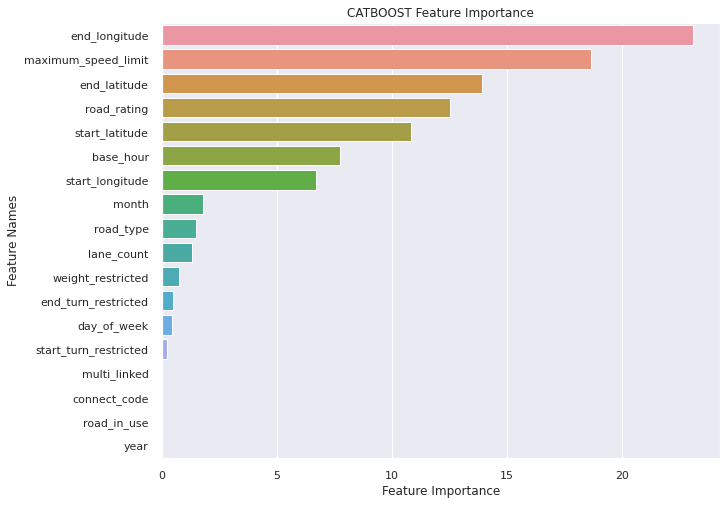

In [ ]:
plot_feature_importance(model.get_feature_importance(),x_valid.columns,'CATBOOST')